In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from PIL import Image
from sklearn.cluster import DBSCAN
import os

dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'
dataset_file = 'filtered_dataset.npy' 
dataset_array = np.load(dataset_processed_path + dataset_file)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


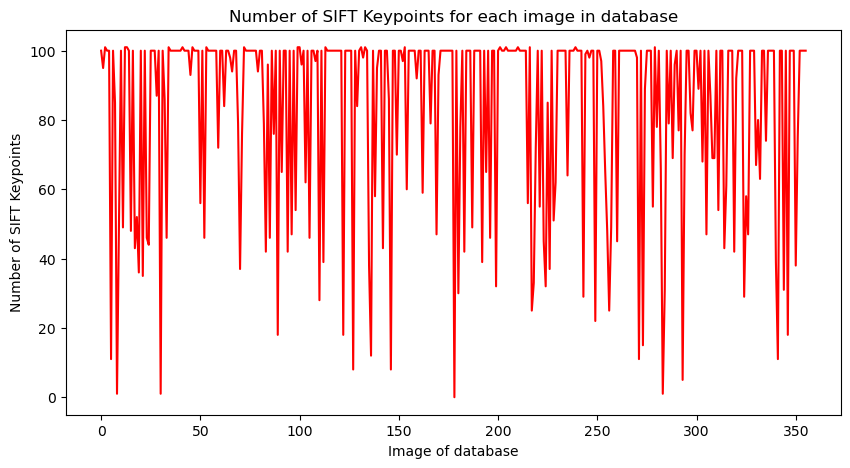

Number of images with exactly 100 keypoints:  200
Number of images with less than 80 keypoints:  104
Number of images with 0 keypoints:  1


In [3]:
# Initialize SIFT detector
num_features = 100
sift = cv.SIFT_create(nfeatures=num_features)

# Path to image folder
image_folder = dataset_processed_path

# Get list of image file names
image_files = os.listdir(image_folder)
# Filter the list to include only .jpg files
image_files = [file for file in image_files if file.endswith('.jpg')]

# Initialize lists to store image names and number of keypoints
image_names = []
num_keypoints = []
i = 0
num_images_100_keypoints = 0
num_images_less_than_100_keypoints = 0
num_0_keypoint = 0

# Iterate over each image
for image_file in image_files:
    # Load image
    image = cv.imread(os.path.join(image_folder, image_file), cv.IMREAD_GRAYSCALE)

    # Compute sift descriptors
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is None:
        image_names.append(i)
        num_keypoints.append(0)
        num_images_less_than_100_keypoints += 1
        num_0_keypoint += 1
    else:
        # Store image name and number of keypoints
        image_names.append(i)
        num_keypoints.append(len(descriptors))
        if len(descriptors) == 100:
            num_images_100_keypoints += 1
        elif len(descriptors) < 80:
            num_images_less_than_100_keypoints += 1
    i = i+1

# Create plot
plt.figure(figsize=(10, 5))
plt.plot(image_names, num_keypoints,'r')
plt.xlabel('Image of database')
plt.ylabel('Number of SIFT Keypoints')
plt.title('Number of SIFT Keypoints for each image in database')  
plt.show()

print("Number of images with exactly 100 keypoints: ", num_images_100_keypoints)
print("Number of images with less than 80 keypoints: ", num_images_less_than_100_keypoints)
print("Number of images with 0 keypoints: ", num_0_keypoint)

### Create SIFT dataset

In [21]:
# Initialize sift
num_features = 100
sift = cv.SIFT_create(nfeatures=num_features)

# Path to your image folder
image_folder = dataset_processed_path

# Get list of image file names
image_files = os.listdir(image_folder)
# Filter the list to include only .jpg files
image_files = [file for file in image_files if file.endswith('.jpg')]

# sift dataset
sift_descriptors = []

# Initialize lists to store image names and number of keypoints
image_names = []
num_keypoints = []
i = 0
# Iterate over each image
for image_file in image_files:
    # Load image
    image = cv.imread(os.path.join(image_folder, image_file), 0)  # load in grayscale

    # Compute sift descriptors
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is None:
        # Initialize descriptors as an array of zeros
        descriptors = np.zeros((num_features, 128))
    else:
        if len(descriptors) < num_features:
            delta = num_features - len(descriptors)
            descriptors = np.concatenate((descriptors, np.zeros((delta, 128))))
        elif len(descriptors) > num_features:
            descriptors = descriptors[:num_features, :]
    
    # Add descriptors to sift dataset list; if there are less than 100 keypoints, add zeros
    sift_descriptors.append(descriptors)

# Convert sift dataset to numpy array (images, keypoints, features)
sift_descriptors = np.array(sift_descriptors, dtype=float)
np.save(dataset_processed_path + 'sift.npy', sift_descriptors)

In [15]:
np.save(dataset_processed_path + 'sift.npy', sift_descriptors)

In [22]:
sift_descriptors = np.load(dataset_processed_path + 'sift.npy')
print(sift_descriptors.dtype, sift_descriptors.shape)
print(sift_descriptors[0])

float64 (356, 100, 128)
[[75. 35.  0. ... 15.  0.  0.]
 [13.  1.  0. ... 29.  0.  2.]
 [ 0.  1.  3. ...  0.  0.  7.]
 ...
 [ 7.  0.  0. ...  0.  0.  0.]
 [ 3.  0.  0. ...  0.  0.  0.]
 [35. 94. 14. ...  0.  0.  0.]]


# Image Retrieval

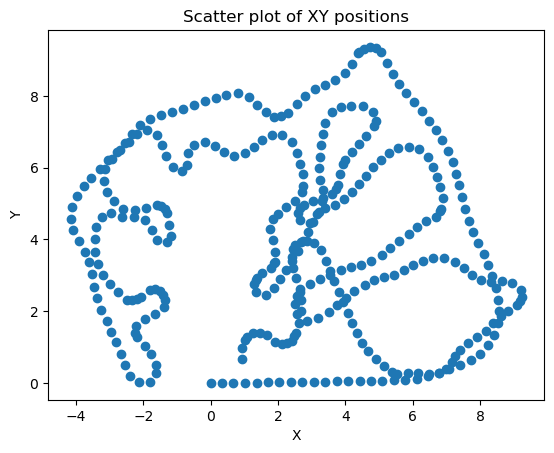

In [26]:
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')
positions = filtered_dataset[:, 1:3]

# Create scatter plot
plt.scatter(positions[:, 0], positions[:, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter plot of XY positions')
plt.show()

### TEST 1

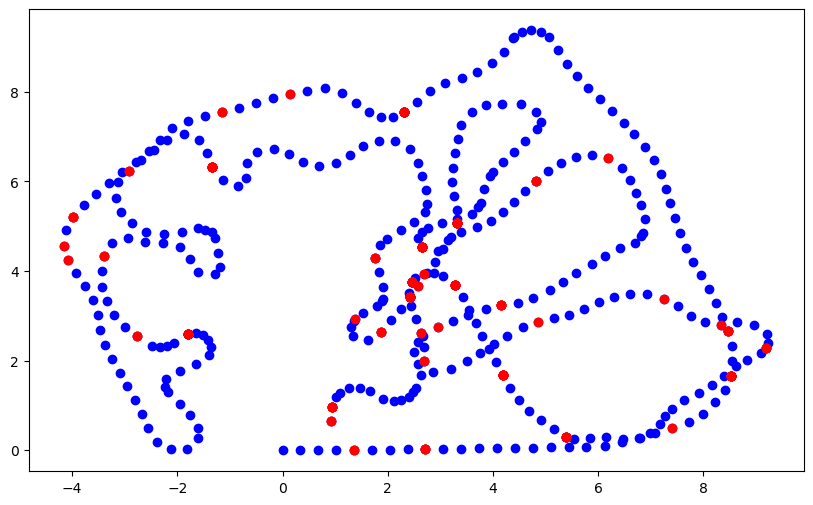

In [31]:
N = 10

# Initialize SIFT detector
num_features = 100
sift = cv.SIFT_create(nfeatures=num_features)

# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)

# Load the SIFT dataset and filtered dataset
sift_dataset = np.load(dataset_processed_path + 'sift.npy')
sift_dataset = sift_dataset.astype(np.float32)
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

# Get the list of query images
image_reloc_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/test_3/'
query_images = os.listdir(image_reloc_path)

# Pre-load all query images
query_images = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in query_images]

# Initialize a list to store the top N poses for each query image
all_top_N_poses = []

for image_reloc in query_images:
    # Calculate sift descriptors for the query image
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)

    # Store the number of good matches for each image
    good_matches_per_image = np.zeros(sift_dataset.shape[0], dtype=int)

    # Match the query image's descriptors with each database image's descriptors
    for i in range(sift_dataset.shape[0]):
        # Convert the descriptors to float32
        db_descriptors = sift_dataset[i].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)

        # Apply ratio test
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

        # Store the number of good matches
        good_matches_per_image[i] = len(good_matches)


    # Sort by the number of matches (in descending order)
    top_N_indices = np.argsort(good_matches_per_image)[::-1][:N]

    # Get the poses of the top N images
    top_N_poses = filtered_dataset[top_N_indices]

    # Add the top N poses to the list of all top N poses
    all_top_N_poses.append(top_N_poses)

# Convert the list of all top N poses to a numpy array
all_top_N_poses = np.concatenate(all_top_N_poses)

plt.figure(figsize=(10, 6))
# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the poses of the top N images in red
plt.scatter(all_top_N_poses[:, 1], all_top_N_poses[:, 2], color='red')

plt.show()

### TEST 2

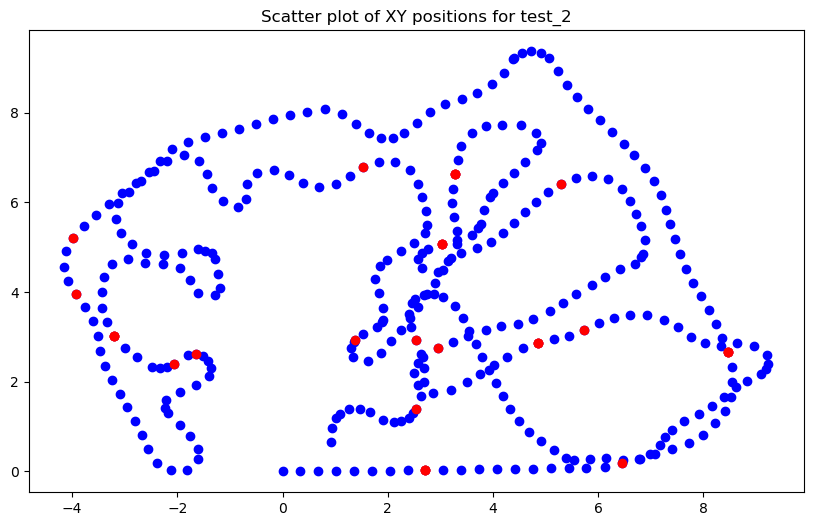

In [32]:
N = 10
test = 'test_2'

# Initialize SIFT detector
num_features = 100
sift = cv.SIFT_create(nfeatures=num_features)

# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)

# Load the SIFT dataset and filtered dataset
sift_dataset = np.load(dataset_processed_path + 'sift.npy')
sift_dataset = sift_dataset.astype(np.float32)
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

# Get the list of query images
image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{test}/'
query_images = os.listdir(image_reloc_path)

# Pre-load all query images
query_images = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in query_images]

# Initialize a list to store the top N poses for each query image
all_top_N_poses = []

for image_reloc in query_images:
    # Calculate sift descriptors for the query image
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)

    # Store the number of good matches for each image
    good_matches_per_image = np.zeros(sift_dataset.shape[0], dtype=int)

    # Match the query image's descriptors with each database image's descriptors
    for i in range(sift_dataset.shape[0]):
        # Convert the descriptors to float32
        db_descriptors = sift_dataset[i].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)

        # Apply ratio test
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

        # Store the number of good matches
        good_matches_per_image[i] = len(good_matches)


    # Sort by the number of matches (in descending order)
    top_N_indices = np.argsort(good_matches_per_image)[::-1][:N]

    # Get the poses of the top N images
    top_N_poses = filtered_dataset[top_N_indices]

    # Add the top N poses to the list of all top N poses
    all_top_N_poses.append(top_N_poses)

# Convert the list of all top N poses to a numpy array
all_top_N_poses = np.concatenate(all_top_N_poses)

plt.figure(figsize=(10, 6))
# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the poses of the top N images in red
plt.scatter(all_top_N_poses[:, 1], all_top_N_poses[:, 2], color='red')
plt.title(f'Scatter plot of XY positions for {test}')
plt.show()

### TEST 3

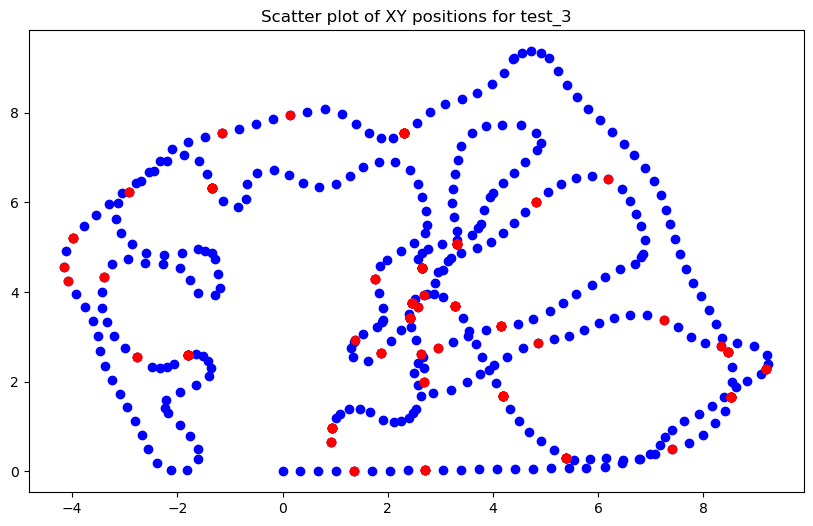

In [33]:
N = 10
test = 'test_3'

# Initialize SIFT detector
num_features = 100
sift = cv.SIFT_create(nfeatures=num_features)

# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)

# Load the SIFT dataset and filtered dataset
sift_dataset = np.load(dataset_processed_path + 'sift.npy')
sift_dataset = sift_dataset.astype(np.float32)
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

# Get the list of query images
image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{test}/'
query_images = os.listdir(image_reloc_path)

# Pre-load all query images
query_images = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in query_images]

# Initialize a list to store the top N poses for each query image
all_top_N_poses = []

for image_reloc in query_images:
    # Calculate sift descriptors for the query image
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)

    # Store the number of good matches for each image
    good_matches_per_image = np.zeros(sift_dataset.shape[0], dtype=int)

    # Match the query image's descriptors with each database image's descriptors
    for i in range(sift_dataset.shape[0]):
        # Convert the descriptors to float32
        db_descriptors = sift_dataset[i].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)

        # Apply ratio test
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

        # Store the number of good matches
        good_matches_per_image[i] = len(good_matches)


    # Sort by the number of matches (in descending order)
    top_N_indices = np.argsort(good_matches_per_image)[::-1][:N]

    # Get the poses of the top N images
    top_N_poses = filtered_dataset[top_N_indices]

    # Add the top N poses to the list of all top N poses
    all_top_N_poses.append(top_N_poses)

# Convert the list of all top N poses to a numpy array
all_top_N_poses = np.concatenate(all_top_N_poses)

plt.figure(figsize=(10, 6))
# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the poses of the top N images in red
plt.scatter(all_top_N_poses[:, 1], all_top_N_poses[:, 2], color='red')
plt.title(f'Scatter plot of XY positions for {test}')
plt.show()

### TEST 4

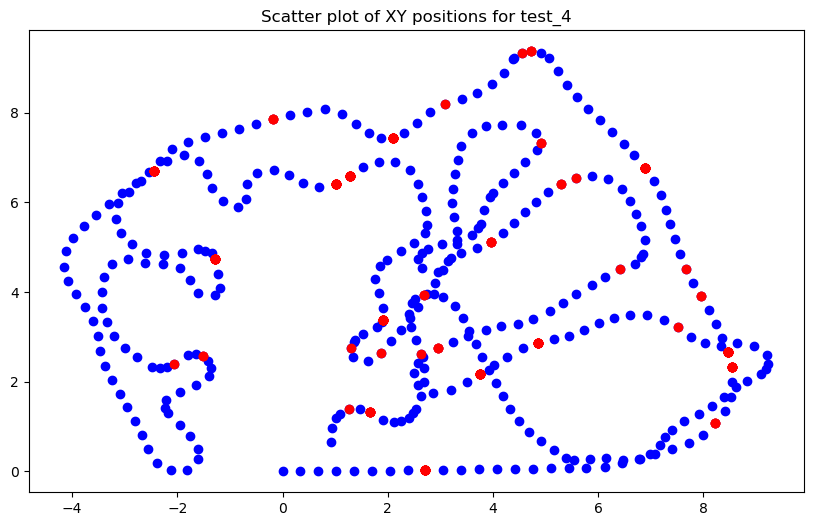

In [34]:
N = 10
test = 'test_4'

# Initialize SIFT detector
num_features = 100
sift = cv.SIFT_create(nfeatures=num_features)

# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)

# Load the SIFT dataset and filtered dataset
sift_dataset = np.load(dataset_processed_path + 'sift.npy')
sift_dataset = sift_dataset.astype(np.float32)
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

# Get the list of query images
image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{test}/'
query_images = os.listdir(image_reloc_path)

# Pre-load all query images
query_images = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in query_images]

# Initialize a list to store the top N poses for each query image
all_top_N_poses = []

for image_reloc in query_images:
    # Calculate sift descriptors for the query image
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)

    # Store the number of good matches for each image
    good_matches_per_image = np.zeros(sift_dataset.shape[0], dtype=int)

    # Match the query image's descriptors with each database image's descriptors
    for i in range(sift_dataset.shape[0]):
        # Convert the descriptors to float32
        db_descriptors = sift_dataset[i].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)

        # Apply ratio test
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

        # Store the number of good matches
        good_matches_per_image[i] = len(good_matches)


    # Sort by the number of matches (in descending order)
    top_N_indices = np.argsort(good_matches_per_image)[::-1][:N]

    # Get the poses of the top N images
    top_N_poses = filtered_dataset[top_N_indices]

    # Add the top N poses to the list of all top N poses
    all_top_N_poses.append(top_N_poses)

# Convert the list of all top N poses to a numpy array
all_top_N_poses = np.concatenate(all_top_N_poses)

plt.figure(figsize=(10, 6))
# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the poses of the top N images in red
plt.scatter(all_top_N_poses[:, 1], all_top_N_poses[:, 2], color='red')
plt.title(f'Scatter plot of XY positions for {test}')
plt.show()

### TEST 5

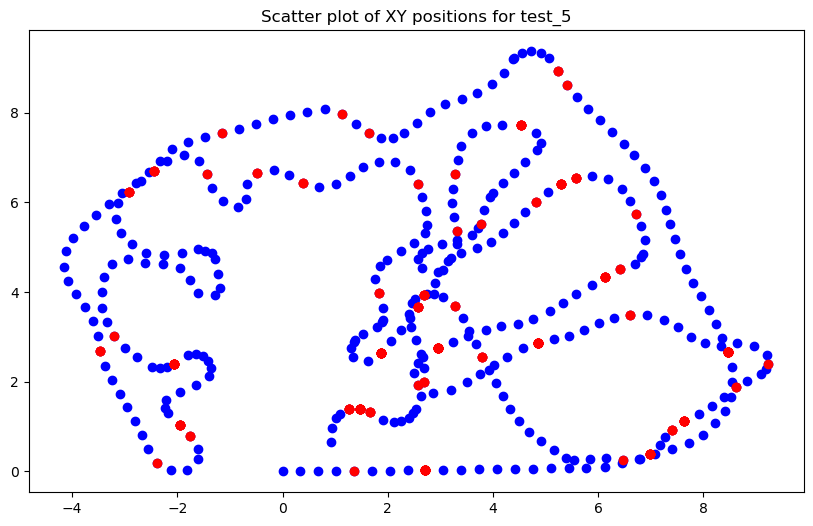

In [35]:
N = 10
test = 'test_5'

# Initialize SIFT detector
num_features = 100
sift = cv.SIFT_create(nfeatures=num_features)

# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)

# Load the SIFT dataset and filtered dataset
sift_dataset = np.load(dataset_processed_path + 'sift.npy')
sift_dataset = sift_dataset.astype(np.float32)
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

# Get the list of query images
image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{test}/'
query_images = os.listdir(image_reloc_path)

# Pre-load all query images
query_images = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in query_images]

# Initialize a list to store the top N poses for each query image
all_top_N_poses = []

for image_reloc in query_images:
    # Calculate sift descriptors for the query image
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)

    # Store the number of good matches for each image
    good_matches_per_image = np.zeros(sift_dataset.shape[0], dtype=int)

    # Match the query image's descriptors with each database image's descriptors
    for i in range(sift_dataset.shape[0]):
        # Convert the descriptors to float32
        db_descriptors = sift_dataset[i].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)

        # Apply ratio test
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

        # Store the number of good matches
        good_matches_per_image[i] = len(good_matches)


    # Sort by the number of matches (in descending order)
    top_N_indices = np.argsort(good_matches_per_image)[::-1][:N]

    # Get the poses of the top N images
    top_N_poses = filtered_dataset[top_N_indices]

    # Add the top N poses to the list of all top N poses
    all_top_N_poses.append(top_N_poses)

# Convert the list of all top N poses to a numpy array
all_top_N_poses = np.concatenate(all_top_N_poses)

plt.figure(figsize=(10, 6))
# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the poses of the top N images in red
plt.scatter(all_top_N_poses[:, 1], all_top_N_poses[:, 2], color='red')
plt.title(f'Scatter plot of XY positions for {test}')
plt.show()

### TEST 6

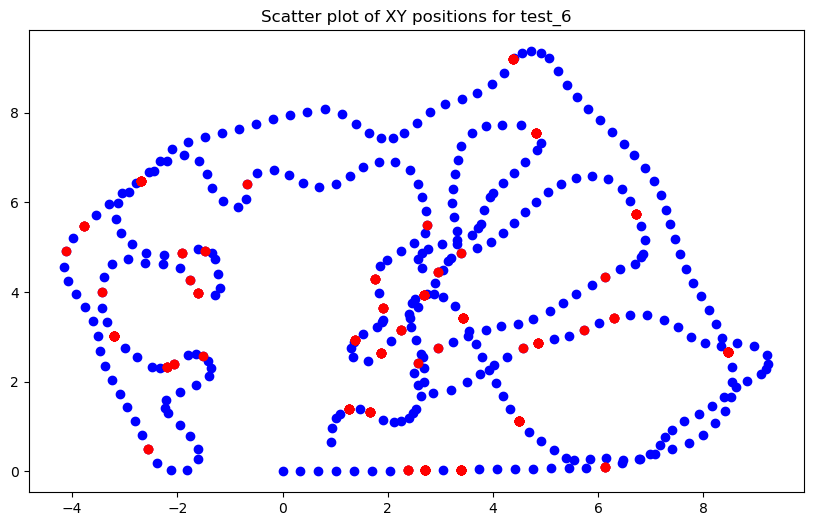

In [36]:
N = 10
test = 'test_6'

# Initialize SIFT detector
num_features = 100
sift = cv.SIFT_create(nfeatures=num_features)

# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)

# Load the SIFT dataset and filtered dataset
sift_dataset = np.load(dataset_processed_path + 'sift.npy')
sift_dataset = sift_dataset.astype(np.float32)
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

# Get the list of query images
image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{test}/'
query_images = os.listdir(image_reloc_path)

# Pre-load all query images
query_images = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in query_images]

# Initialize a list to store the top N poses for each query image
all_top_N_poses = []

for image_reloc in query_images:
    # Calculate sift descriptors for the query image
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)

    # Store the number of good matches for each image
    good_matches_per_image = np.zeros(sift_dataset.shape[0], dtype=int)

    # Match the query image's descriptors with each database image's descriptors
    for i in range(sift_dataset.shape[0]):
        # Convert the descriptors to float32
        db_descriptors = sift_dataset[i].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)

        # Apply ratio test
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

        # Store the number of good matches
        good_matches_per_image[i] = len(good_matches)


    # Sort by the number of matches (in descending order)
    top_N_indices = np.argsort(good_matches_per_image)[::-1][:N]

    # Get the poses of the top N images
    top_N_poses = filtered_dataset[top_N_indices]

    # Add the top N poses to the list of all top N poses
    all_top_N_poses.append(top_N_poses)

# Convert the list of all top N poses to a numpy array
all_top_N_poses = np.concatenate(all_top_N_poses)

plt.figure(figsize=(10, 6))
# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the poses of the top N images in red
plt.scatter(all_top_N_poses[:, 1], all_top_N_poses[:, 2], color='red')
plt.title(f'Scatter plot of XY positions for {test}')
plt.show()

# VGG16 + SIFT

In [19]:
import os
import re
import cv2 as cv
import numpy as np
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image as kimage
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import time
from sklearn.cluster import DBSCAN
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'
dataset_file = 'filtered_dataset.npy' 
dataset_array = np.load(dataset_processed_path + dataset_file)

### TEST 1

1/1 [==============================] - 0s 100ms/step
VGG16: 0.6080093383789062 seconds
SIFT:  0.15965652465820312 seconds


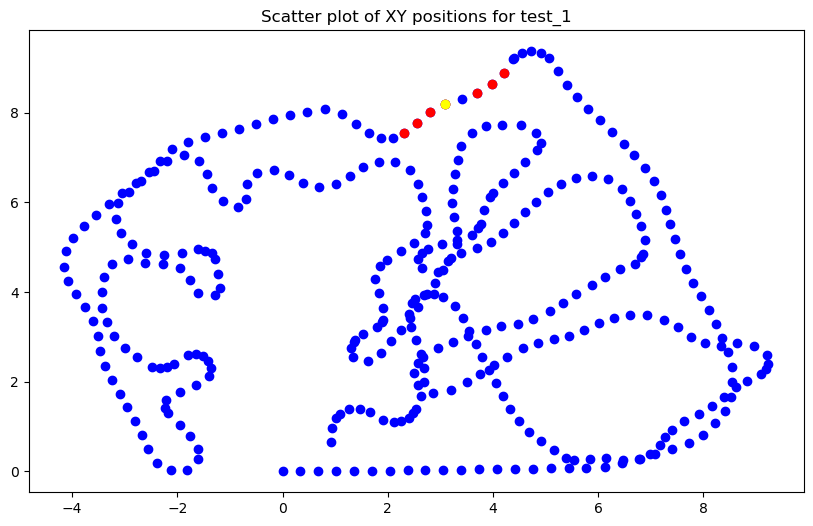

In [44]:
filter = True
N = 5
test = 'test_1'

# Initialize VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Initialize sift detector
num_features = 100
sift = cv.SIFT_create(nfeatures=num_features)

# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)

# Load VGG16, sift dataset and filtered dataset
vgg16_dataset = np.load(dataset_processed_path + 'vgg16.npy')
sift_dataset = np.load(dataset_processed_path + 'sift.npy')
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

# Get the list of query images
image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{test}/'
image_list = os.listdir(image_reloc_path)

# Pre-load all query images
query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
query_images_vgg16 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]

# Initialize a list to store the top N poses for each query image for VGG16 model
all_top_N_poses_vgg16 = []
top_indices_all_queries = []

# TIMER VGG16
start_time_vgg16 = time.time()
### Visual Place Recognition with VGG16: take top poses, concatenating
for image_reloc in query_images_vgg16:
    # Calculate VGG16 descriptors for the query image
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean distance between the query image's descriptors and each database image's descriptors
    similarities = np.array([np.linalg.norm(vgg16_feature - db_feature) for db_feature in vgg16_dataset[:, 8:]])
    
    # Top N images
    top_N_indices = similarities.argsort()[:N]

    # Add the indices of the top N images to the list
    top_indices_all_queries.extend(top_N_indices)
  
# Remove duplicates from the list of top indices for all queries
top_indices_all_queries = list(set(top_indices_all_queries))  

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=0.35, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    filtered_top_positions = filtered_dataset[top_indices_all_queries][clustering.labels_ != -1]
    top_indices_all_queries = np.array(top_indices_all_queries)[clustering.labels_ != -1]
    
# Stop the timer
end_time_vgg16 = time.time()
# Calculate the elapsed time
elapsed_time_vgg16 = end_time_vgg16 - start_time_vgg16

# TIMER SIFT
start_time_sift = time.time()
### Calculate sift descriptors for the query images and compute similarity with the top images calculated with VGG16
for image_reloc in query_images_sift:
    
    # Calculate sift descriptors for the query image
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    
    # Store the number of matches for each image
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    
    # Match the query image's descriptors with each of the top images' descriptors
    for i, index in enumerate(top_indices_all_queries):
        # Convert the descriptors to float32
        db_descriptors = sift_dataset[index].astype(np.float32)
        # Find two best matches for each descriptor
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        # Apply ratio test
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        # Store the number of good matches
        good_matches_per_image[i] = len(good_matches)

    # Get the index of the image with the most good matches
    best_match_index = np.argmax(good_matches_per_image)

    # Get the index in the original dataset
    original_index = top_indices_all_queries[best_match_index]

    # Get the pose of the best match
    best_match_pose = filtered_dataset[original_index]
# Stop the timer SIFT
end_time_sift = time.time()
# Calculate the elapsed time
elapsed_time_sift = end_time_sift - start_time_sift
print(f"VGG16: {elapsed_time_vgg16} seconds")
print(f"SIFT:  {elapsed_time_sift} seconds")


# Create plot
plt.figure(figsize=(10, 6))

# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the pose of the best match after VGG16 in red
plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')

# Plot the pose of the best match after sift in yellow
plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
plt.title(f'Scatter plot of XY positions for {test}')
plt.show()

### TEST 2

In [20]:
filter = True
N = 5
test = 'test_2'

# Initialize VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Initialize sift detector
num_features = 100
sift = cv.SIFT_create(nfeatures=num_features)

# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)

# Load VGG16, sift dataset and filtered dataset
vgg16_dataset = np.load(dataset_processed_path + 'vgg16.npy')
sift_dataset = np.load(dataset_processed_path + 'sift.npy')
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

# Get the list of query images
image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{test}/'
image_list = os.listdir(image_reloc_path)

# Pre-load all query images
query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
query_images_vgg16 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]

# Initialize a list to store the top N poses for each query image for VGG16 model
all_top_N_poses_vgg16 = []
top_indices_all_queries = []

# TIMER VGG16
start_time_vgg16 = time.time()
### Visual Place Recognition with VGG16: take top poses, concatenating
for image_reloc in query_images_vgg16:
    # Calculate VGG16 descriptors for the query image
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean distance between the query image's descriptors and each database image's descriptors
    similarities = np.array([np.linalg.norm(vgg16_feature - db_feature) for db_feature in vgg16_dataset[:, 8:]])
    
    # Top N images
    top_N_indices = similarities.argsort()[:N]

    # Add the indices of the top N images to the list
    top_indices_all_queries.extend(top_N_indices)
  
# Remove duplicates from the list of top indices for all queries
top_indices_all_queries = list(set(top_indices_all_queries))  

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=0.35, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    filtered_top_positions = filtered_dataset[top_indices_all_queries][clustering.labels_ != -1]
    top_indices_all_queries = np.array(top_indices_all_queries)[clustering.labels_ != -1]
    
# Stop the timer
end_time_vgg16 = time.time()
# Calculate the elapsed time
elapsed_time_vgg16 = end_time_vgg16 - start_time_vgg16

# TIMER SIFT
start_time_sift = time.time()
### Calculate sift descriptors for the query images and compute similarity with the top images calculated with VGG16
for image_reloc in query_images_sift:
    
    # Calculate sift descriptors for the query image
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    
    # Store the number of matches for each image
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    
    # Match the query image's descriptors with each of the top images' descriptors
    for i, index in enumerate(top_indices_all_queries):
        # Convert the descriptors to float32
        db_descriptors = sift_dataset[index].astype(np.float32)
        # Find two best matches for each descriptor
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        # Apply ratio test
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        # Store the number of good matches
        good_matches_per_image[i] = len(good_matches)

    # Get the index of the image with the most good matches
    best_match_index = np.argmax(good_matches_per_image)

    # Get the index in the original dataset
    original_index = top_indices_all_queries[best_match_index]

    # Get the pose of the best match
    best_match_pose = filtered_dataset[original_index]
# Stop the timer SIFT
end_time_sift = time.time()
# Calculate the elapsed time
elapsed_time_sift = end_time_sift - start_time_sift
print(f"VGG16: {elapsed_time_vgg16} seconds")
print(f"SIFT:  {elapsed_time_sift} seconds")


# Create plot
plt.figure(figsize=(10, 6))

# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the pose of the best match after VGG16 in red
plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')

# Plot the pose of the best match after sift in yellow
plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
plt.title(f'Scatter plot of XY positions for {test}')
plt.show()

1/1 [==============================] - 0s 92ms/step


ValueError: attempt to get argmax of an empty sequence

### TEST 3

1/1 [==============================] - 0s 103ms/step
VGG16: 3.2300305366516113 seconds
SIFT:  0.7223284244537354 seconds


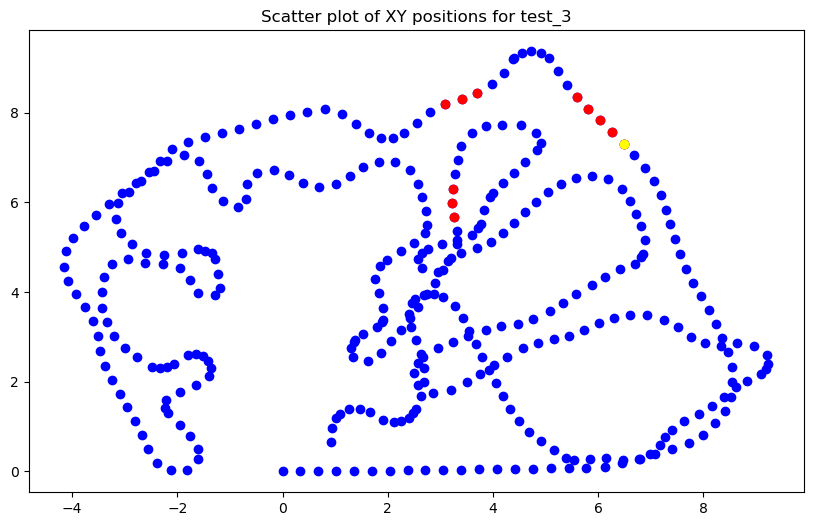

In [21]:
filter = True
N = 5
test = 'test_3'

# Initialize VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Initialize sift detector
num_features = 100
sift = cv.SIFT_create(nfeatures=num_features)

# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)

# Load VGG16, sift dataset and filtered dataset
vgg16_dataset = np.load(dataset_processed_path + 'vgg16.npy')
sift_dataset = np.load(dataset_processed_path + 'sift.npy')
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

# Get the list of query images
image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{test}/'
image_list = os.listdir(image_reloc_path)

# Pre-load all query images
query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
query_images_vgg16 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]

# Initialize a list to store the top N poses for each query image for VGG16 model
all_top_N_poses_vgg16 = []
top_indices_all_queries = []

# TIMER VGG16
start_time_vgg16 = time.time()
### Visual Place Recognition with VGG16: take top poses, concatenating
for image_reloc in query_images_vgg16:
    # Calculate VGG16 descriptors for the query image
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean distance between the query image's descriptors and each database image's descriptors
    similarities = np.array([np.linalg.norm(vgg16_feature - db_feature) for db_feature in vgg16_dataset[:, 8:]])
    
    # Top N images
    top_N_indices = similarities.argsort()[:N]

    # Add the indices of the top N images to the list
    top_indices_all_queries.extend(top_N_indices)
  
# Remove duplicates from the list of top indices for all queries
top_indices_all_queries = list(set(top_indices_all_queries))  

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=0.35, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    filtered_top_positions = filtered_dataset[top_indices_all_queries][clustering.labels_ != -1]
    top_indices_all_queries = np.array(top_indices_all_queries)[clustering.labels_ != -1]
    
# Stop the timer
end_time_vgg16 = time.time()
# Calculate the elapsed time
elapsed_time_vgg16 = end_time_vgg16 - start_time_vgg16

# TIMER SIFT
start_time_sift = time.time()
### Calculate sift descriptors for the query images and compute similarity with the top images calculated with VGG16
for image_reloc in query_images_sift:
    
    # Calculate sift descriptors for the query image
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    
    # Store the number of matches for each image
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    
    # Match the query image's descriptors with each of the top images' descriptors
    for i, index in enumerate(top_indices_all_queries):
        # Convert the descriptors to float32
        db_descriptors = sift_dataset[index].astype(np.float32)
        # Find two best matches for each descriptor
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        # Apply ratio test
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        # Store the number of good matches
        good_matches_per_image[i] = len(good_matches)

    # Get the index of the image with the most good matches
    best_match_index = np.argmax(good_matches_per_image)

    # Get the index in the original dataset
    original_index = top_indices_all_queries[best_match_index]

    # Get the pose of the best match
    best_match_pose = filtered_dataset[original_index]
# Stop the timer SIFT
end_time_sift = time.time()
# Calculate the elapsed time
elapsed_time_sift = end_time_sift - start_time_sift
print(f"VGG16: {elapsed_time_vgg16} seconds")
print(f"SIFT:  {elapsed_time_sift} seconds")


# Create plot
plt.figure(figsize=(10, 6))

# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the pose of the best match after VGG16 in red
plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')

# Plot the pose of the best match after sift in yellow
plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
plt.title(f'Scatter plot of XY positions for {test}')
plt.show()

### TEST 4

1/1 [==============================] - 0s 97ms/step
VGG16: 5.228980779647827 seconds
SIFT:  0.8130438327789307 seconds


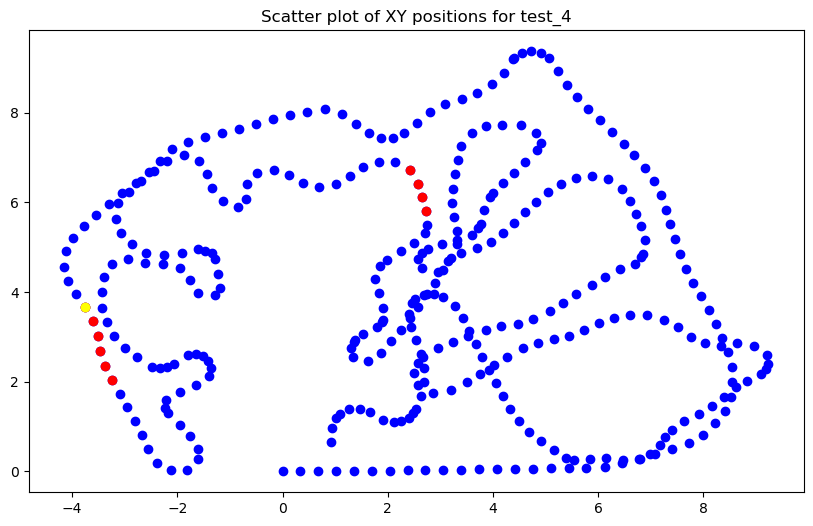

In [47]:
filter = True
N = 5
test = 'test_4'

# Initialize VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Initialize sift detector
num_features = 100
sift = cv.SIFT_create(nfeatures=num_features)

# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)

# Load VGG16, sift dataset and filtered dataset
vgg16_dataset = np.load(dataset_processed_path + 'vgg16.npy')
sift_dataset = np.load(dataset_processed_path + 'sift.npy')
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

# Get the list of query images
image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{test}/'
image_list = os.listdir(image_reloc_path)

# Pre-load all query images
query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
query_images_vgg16 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]

# Initialize a list to store the top N poses for each query image for VGG16 model
all_top_N_poses_vgg16 = []
top_indices_all_queries = []

# TIMER VGG16
start_time_vgg16 = time.time()
### Visual Place Recognition with VGG16: take top poses, concatenating
for image_reloc in query_images_vgg16:
    # Calculate VGG16 descriptors for the query image
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean distance between the query image's descriptors and each database image's descriptors
    similarities = np.array([np.linalg.norm(vgg16_feature - db_feature) for db_feature in vgg16_dataset[:, 8:]])
    
    # Top N images
    top_N_indices = similarities.argsort()[:N]

    # Add the indices of the top N images to the list
    top_indices_all_queries.extend(top_N_indices)
  
# Remove duplicates from the list of top indices for all queries
top_indices_all_queries = list(set(top_indices_all_queries))  

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=0.35, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    filtered_top_positions = filtered_dataset[top_indices_all_queries][clustering.labels_ != -1]
    top_indices_all_queries = np.array(top_indices_all_queries)[clustering.labels_ != -1]
    
# Stop the timer
end_time_vgg16 = time.time()
# Calculate the elapsed time
elapsed_time_vgg16 = end_time_vgg16 - start_time_vgg16

# TIMER SIFT
start_time_sift = time.time()
### Calculate sift descriptors for the query images and compute similarity with the top images calculated with VGG16
for image_reloc in query_images_sift:
    
    # Calculate sift descriptors for the query image
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    
    # Store the number of matches for each image
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    
    # Match the query image's descriptors with each of the top images' descriptors
    for i, index in enumerate(top_indices_all_queries):
        # Convert the descriptors to float32
        db_descriptors = sift_dataset[index].astype(np.float32)
        # Find two best matches for each descriptor
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        # Apply ratio test
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        # Store the number of good matches
        good_matches_per_image[i] = len(good_matches)

    # Get the index of the image with the most good matches
    best_match_index = np.argmax(good_matches_per_image)

    # Get the index in the original dataset
    original_index = top_indices_all_queries[best_match_index]

    # Get the pose of the best match
    best_match_pose = filtered_dataset[original_index]
# Stop the timer SIFT
end_time_sift = time.time()
# Calculate the elapsed time
elapsed_time_sift = end_time_sift - start_time_sift
print(f"VGG16: {elapsed_time_vgg16} seconds")
print(f"SIFT:  {elapsed_time_sift} seconds")


# Create plot
plt.figure(figsize=(10, 6))

# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the pose of the best match after VGG16 in red
plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')

# Plot the pose of the best match after sift in yellow
plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
plt.title(f'Scatter plot of XY positions for {test}')
plt.show()

### TEST 5

1/1 [==============================] - 0s 96ms/step
VGG16: 3.9846436977386475 seconds
SIFT:  0.8485698699951172 seconds


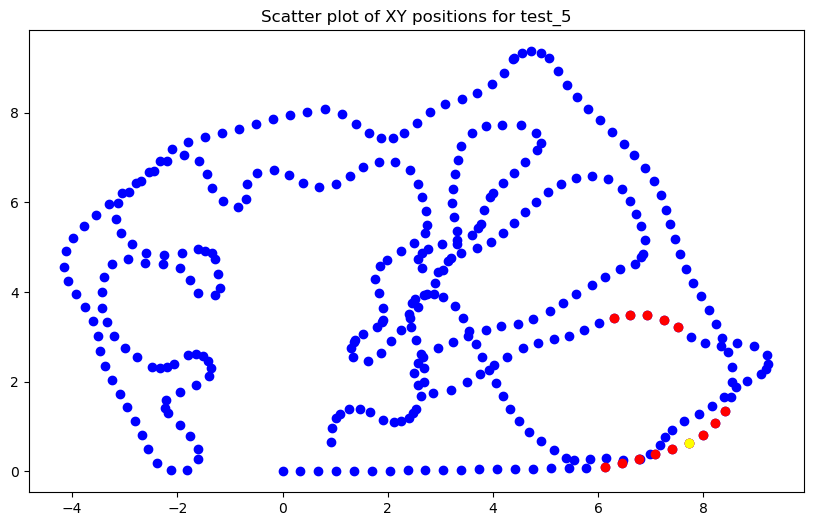

In [48]:
filter = True
N = 5
test = 'test_5'

# Initialize VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Initialize sift detector
num_features = 100
sift = cv.SIFT_create(nfeatures=num_features)

# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)

# Load VGG16, sift dataset and filtered dataset
vgg16_dataset = np.load(dataset_processed_path + 'vgg16.npy')
sift_dataset = np.load(dataset_processed_path + 'sift.npy')
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

# Get the list of query images
image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{test}/'
image_list = os.listdir(image_reloc_path)

# Pre-load all query images
query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
query_images_vgg16 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]

# Initialize a list to store the top N poses for each query image for VGG16 model
all_top_N_poses_vgg16 = []
top_indices_all_queries = []

# TIMER VGG16
start_time_vgg16 = time.time()
### Visual Place Recognition with VGG16: take top poses, concatenating
for image_reloc in query_images_vgg16:
    # Calculate VGG16 descriptors for the query image
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean distance between the query image's descriptors and each database image's descriptors
    similarities = np.array([np.linalg.norm(vgg16_feature - db_feature) for db_feature in vgg16_dataset[:, 8:]])
    
    # Top N images
    top_N_indices = similarities.argsort()[:N]

    # Add the indices of the top N images to the list
    top_indices_all_queries.extend(top_N_indices)
  
# Remove duplicates from the list of top indices for all queries
top_indices_all_queries = list(set(top_indices_all_queries))  

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=0.35, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    filtered_top_positions = filtered_dataset[top_indices_all_queries][clustering.labels_ != -1]
    top_indices_all_queries = np.array(top_indices_all_queries)[clustering.labels_ != -1]
    
# Stop the timer
end_time_vgg16 = time.time()
# Calculate the elapsed time
elapsed_time_vgg16 = end_time_vgg16 - start_time_vgg16

# TIMER SIFT
start_time_sift = time.time()
### Calculate sift descriptors for the query images and compute similarity with the top images calculated with VGG16
for image_reloc in query_images_sift:
    
    # Calculate sift descriptors for the query image
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    
    # Store the number of matches for each image
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    
    # Match the query image's descriptors with each of the top images' descriptors
    for i, index in enumerate(top_indices_all_queries):
        # Convert the descriptors to float32
        db_descriptors = sift_dataset[index].astype(np.float32)
        # Find two best matches for each descriptor
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        # Apply ratio test
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        # Store the number of good matches
        good_matches_per_image[i] = len(good_matches)

    # Get the index of the image with the most good matches
    best_match_index = np.argmax(good_matches_per_image)

    # Get the index in the original dataset
    original_index = top_indices_all_queries[best_match_index]

    # Get the pose of the best match
    best_match_pose = filtered_dataset[original_index]
# Stop the timer SIFT
end_time_sift = time.time()
# Calculate the elapsed time
elapsed_time_sift = end_time_sift - start_time_sift
print(f"VGG16: {elapsed_time_vgg16} seconds")
print(f"SIFT:  {elapsed_time_sift} seconds")


# Create plot
plt.figure(figsize=(10, 6))

# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the pose of the best match after VGG16 in red
plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')

# Plot the pose of the best match after sift in yellow
plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
plt.title(f'Scatter plot of XY positions for {test}')
plt.show()

### TEST 6

1/1 [==============================] - 0s 97ms/step
VGG16: 3.704432964324951 seconds
SIFT:  0.8269102573394775 seconds


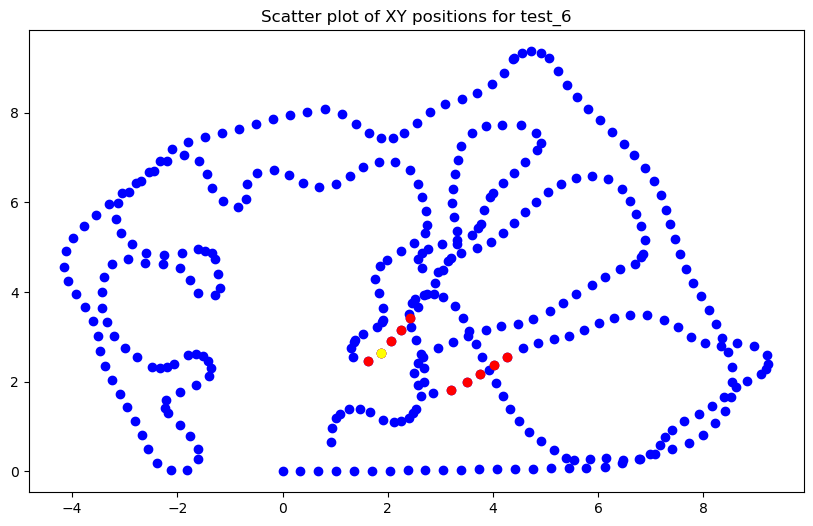

In [49]:
filter = True
N = 5
test = 'test_6'

# Initialize VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Initialize sift detector
num_features = 100
sift = cv.SIFT_create(nfeatures=num_features)

# Initialize Brute-Force matcher
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)

# Load VGG16, sift dataset and filtered dataset
vgg16_dataset = np.load(dataset_processed_path + 'vgg16.npy')
sift_dataset = np.load(dataset_processed_path + 'sift.npy')
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

# Get the list of query images
image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{test}/'
image_list = os.listdir(image_reloc_path)

# Pre-load all query images
query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
query_images_vgg16 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]

# Initialize a list to store the top N poses for each query image for VGG16 model
all_top_N_poses_vgg16 = []
top_indices_all_queries = []

# TIMER VGG16
start_time_vgg16 = time.time()
### Visual Place Recognition with VGG16: take top poses, concatenating
for image_reloc in query_images_vgg16:
    # Calculate VGG16 descriptors for the query image
    img_data = kimage.img_to_array(image_reloc)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = vgg16.predict(img_data)
    
    # Compute Euclidean distance between the query image's descriptors and each database image's descriptors
    similarities = np.array([np.linalg.norm(vgg16_feature - db_feature) for db_feature in vgg16_dataset[:, 8:]])
    
    # Top N images
    top_N_indices = similarities.argsort()[:N]

    # Add the indices of the top N images to the list
    top_indices_all_queries.extend(top_N_indices)
  
# Remove duplicates from the list of top indices for all queries
top_indices_all_queries = list(set(top_indices_all_queries))  

# Filter with DBSCAN
if filter:
    clustering = DBSCAN(eps=0.35, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    filtered_top_positions = filtered_dataset[top_indices_all_queries][clustering.labels_ != -1]
    top_indices_all_queries = np.array(top_indices_all_queries)[clustering.labels_ != -1]
    
# Stop the timer
end_time_vgg16 = time.time()
# Calculate the elapsed time
elapsed_time_vgg16 = end_time_vgg16 - start_time_vgg16

# TIMER SIFT
start_time_sift = time.time()
### Calculate sift descriptors for the query images and compute similarity with the top images calculated with VGG16
for image_reloc in query_images_sift:
    
    # Calculate sift descriptors for the query image
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    
    # Store the number of matches for each image
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    
    # Match the query image's descriptors with each of the top images' descriptors
    for i, index in enumerate(top_indices_all_queries):
        # Convert the descriptors to float32
        db_descriptors = sift_dataset[index].astype(np.float32)
        # Find two best matches for each descriptor
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        # Apply ratio test
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        # Store the number of good matches
        good_matches_per_image[i] = len(good_matches)

    # Get the index of the image with the most good matches
    best_match_index = np.argmax(good_matches_per_image)

    # Get the index in the original dataset
    original_index = top_indices_all_queries[best_match_index]

    # Get the pose of the best match
    best_match_pose = filtered_dataset[original_index]
# Stop the timer SIFT
end_time_sift = time.time()
# Calculate the elapsed time
elapsed_time_sift = end_time_sift - start_time_sift
print(f"VGG16: {elapsed_time_vgg16} seconds")
print(f"SIFT:  {elapsed_time_sift} seconds")

# Create plot
plt.figure(figsize=(10, 6))

# Plot all poses in blue
plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')

# Plot the pose of the best match after VGG16 in red
plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')

# Plot the pose of the best match after sift in yellow
plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
plt.title(f'Scatter plot of XY positions for {test}')
plt.show()

# VGG19 + SIFT

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from sklearn.cluster import DBSCAN
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image as kimage
import os
import time

vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
sift = cv.SIFT_create(nfeatures=100)


2023-12-13 12:06:16.705546: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 12:06:16.962829: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 12:06:16.962923: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 12:06:16.969795: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 12:06:16.969962: I external/local_xla/xla/stream_executor

### TEST 1

1/1 [==============================] - 0s 28ms/step
Load images: 0.007 seconds
VGG19: 0.524 seconds
SIFT:  0.082 seconds
Total: 0.616 seconds


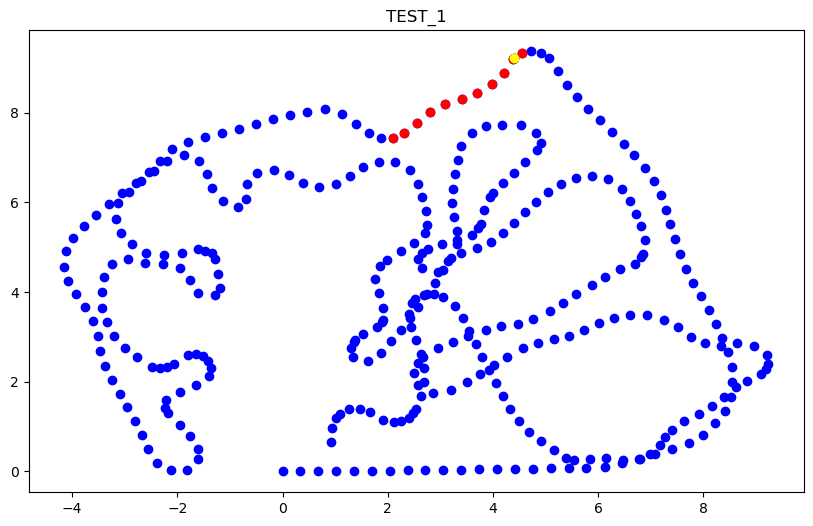

In [5]:
FILTER = True
EPSILON = 0.35
MIN_SAMPLES = 3
N = 10
TEST = 'test_1'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_vgg19 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_vgg19

def process_vgg19(query_images_vgg19, vgg19, vgg19_dataset):
    top_indices_all_queries = []
    for image_reloc in query_images_vgg19:
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        vgg19_feature = vgg19.predict(img_data)
        similarities = np.array([np.linalg.norm(vgg19_feature - db_feature) for db_feature in vgg19_dataset[:, 8:]])
        top_indices_all_queries.extend(similarities.argsort()[:N])
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=0.35, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    #vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    vgg19_dataset = np.load(dataset_processed_path + 'vgg19.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    start_timer_load_images = time.time()
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_sift, query_images_vgg19 = load_images(image_reloc_path)
    end_timer_load_images = time.time()
    
    # VGG19 processing
    start_time_vgg19 = time.time()
    top_indices_all_queries = process_vgg19(query_images_vgg19, vgg19, vgg19_dataset)
    end_time_vgg19 = time.time()
    
    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
  
    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"Load images: {round(end_timer_load_images - start_timer_load_images, 3)} seconds")
    print(f"VGG19: {round(end_time_vgg19 - start_time_vgg19, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"Total: {round(end_time_sift - start_timer_load_images, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)
    #%timeit -r 2 -n 10 process_vgg19(query_images_vgg19, vgg19, vgg19_dataset)

### TEST 2

1/1 [==============================] - 0s 14ms/step
VGG19: 0.405 seconds
SIFT:  0.04 seconds
TOTAL: 0.446 seconds


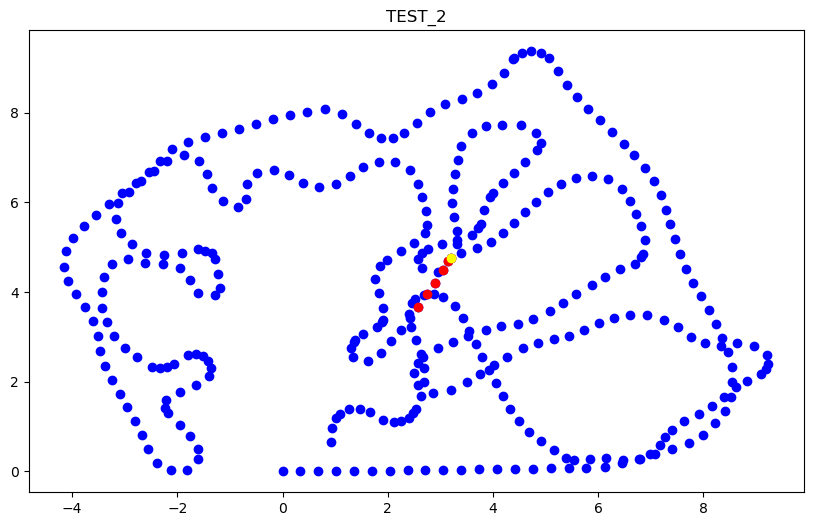

In [8]:
FILTER = True
N = 10
TEST = 'test_2'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_vgg19 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_vgg19

def process_vgg19(query_images_vgg19, vgg19, vgg19_dataset):
    top_indices_all_queries = []
    for image_reloc in query_images_vgg19:
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        vgg19_feature = vgg19.predict(img_data)
        similarities = np.array([np.linalg.norm(vgg19_feature - db_feature) for db_feature in vgg19_dataset[:, 8:]])
        top_indices_all_queries.extend(similarities.argsort()[:N])
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=0.35, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    #vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    vgg19_dataset = np.load(dataset_processed_path + 'vgg19.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_sift, query_images_vgg19 = load_images(image_reloc_path)

    # VGG19 processing
    start_time_vgg19 = time.time()
    top_indices_all_queries = process_vgg19(query_images_vgg19, vgg19, vgg19_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_vgg19 = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"VGG19: {round(end_time_vgg19 - start_time_vgg19, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_vgg19, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)

### TEST 3

1/1 [==============================] - 0s 14ms/step
VGG19: 1.409 seconds
SIFT:  0.042 seconds
TOTAL: 1.451 seconds


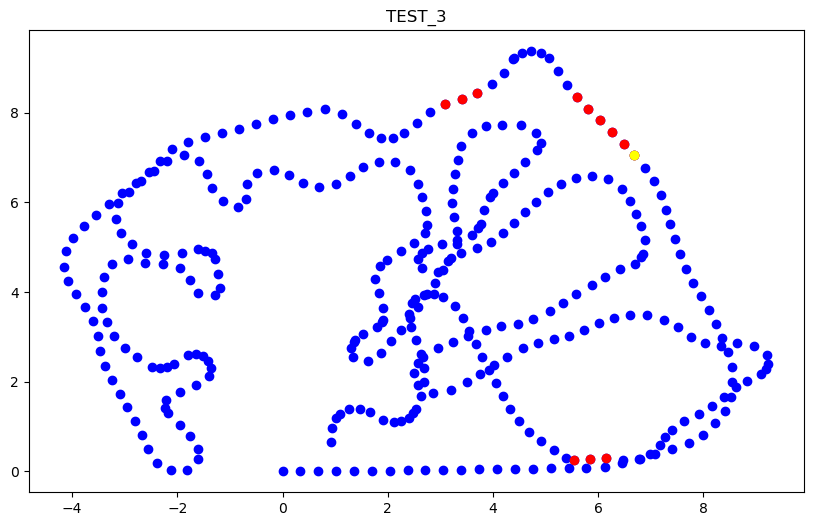

In [9]:
FILTER = True
N = 5
TEST = 'test_3'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_vgg19 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_vgg19

def process_vgg19(query_images_vgg19, vgg19, vgg19_dataset):
    top_indices_all_queries = []
    for image_reloc in query_images_vgg19:
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        vgg19_feature = vgg19.predict(img_data)
        similarities = np.array([np.linalg.norm(vgg19_feature - db_feature) for db_feature in vgg19_dataset[:, 8:]])
        top_indices_all_queries.extend(similarities.argsort()[:N])
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=0.35, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    #vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    vgg19_dataset = np.load(dataset_processed_path + 'vgg19.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_sift, query_images_vgg19 = load_images(image_reloc_path)

    # VGG19 processing
    start_time_vgg19 = time.time()
    top_indices_all_queries = process_vgg19(query_images_vgg19, vgg19, vgg19_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_vgg19 = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"VGG19: {round(end_time_vgg19 - start_time_vgg19, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_vgg19, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)

### TEST 4

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 91ms/step
Predict: 211.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms


Preprocess input: 0.0 ms
1/1 [==============================] - 0s 14ms/step
Predict: 133.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms


Preprocess input: 0.0 ms
1/1 [==============================] - 0s 15ms/step
Predict: 56.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms


Preprocess input: 0.0 ms
1/1 [==============================] - 0s 15ms/step
Predict: 58.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms


Preprocess input: 0.0 ms
1/1 [==============================] - 0s 14ms/step
Predict: 54.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms


Preprocess input: 0.0 ms
1/1 [==============================] - 0s 15ms/step
Predict: 55.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms


Preprocess input: 0.0 ms
1/1 [==============================] - 0s 16ms/step
Predict: 58.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms


Preprocess input: 0.0 ms
1/1 [=========

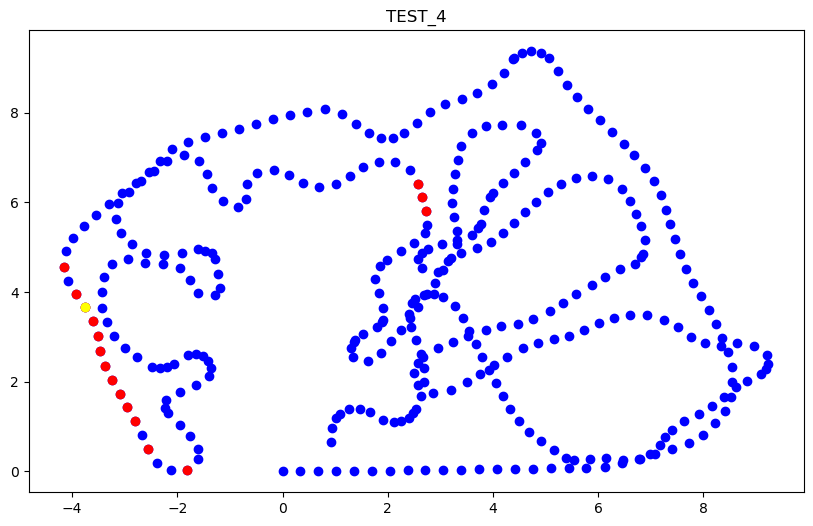

In [18]:
FILTER = True
N = 10
TEST = 'test_4'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_vgg19 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_vgg19

def process_vgg19(query_images_vgg19, vgg19, vgg19_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_vgg19:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        vgg19_feature = vgg19.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(vgg19_feature - db_feature) for db_feature in vgg19_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
        print('\n')
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=0.9, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    #vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    vgg19_dataset = np.load(dataset_processed_path + 'vgg19.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_sift, query_images_vgg19 = load_images(image_reloc_path)

    # VGG19 processing
    start_time_vgg19 = time.time()
    top_indices_all_queries = process_vgg19(query_images_vgg19, vgg19, vgg19_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_vgg19 = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"VGG19: {round(end_time_vgg19 - start_time_vgg19, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_vgg19, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)
    #%timeit -r 2 -n 10 process_vgg19(query_images_vgg19, vgg19, vgg19_dataset)

### TEST 5

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 97ms/step
Predict: 270.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms


Preprocess input: 0.0 ms
1/1 [==============================] - 0s 17ms/step
Predict: 158.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms


Preprocess input: 0.0 ms
1/1 [==============================] - 0s 14ms/step
Predict: 50.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms


Preprocess input: 0.0 ms
1/1 [==============================] - 0s 15ms/step
Predict: 53.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms


Preprocess input: 0.0 ms
1/1 [==============================] - 0s 15ms/step
Predict: 53.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms


Preprocess input: 0.0 ms
1/1 [==============================] - 0s 18ms/step
Predict: 58.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms


Preprocess input: 0.0 ms
1/1 [==============================] - 0s 17ms/step
Predict: 58.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms


Preprocess input: 0.0 ms
1/1 [=========

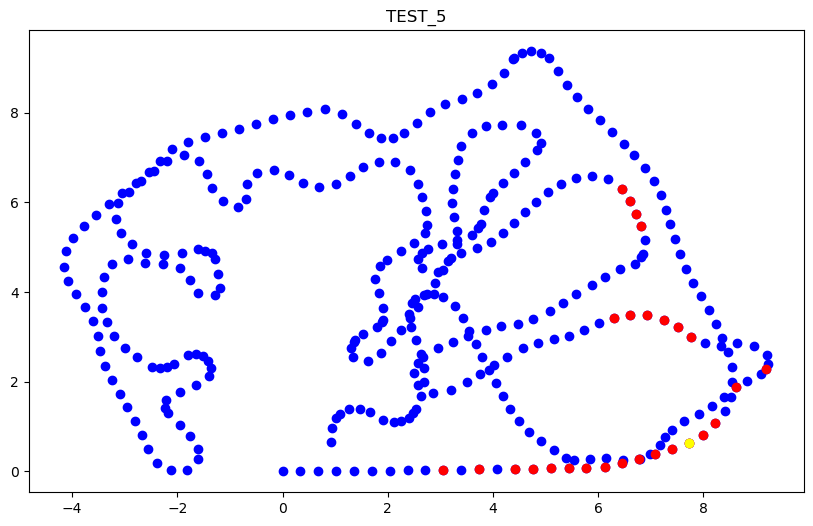

In [5]:
FILTER = True
N = 10
TEST = 'test_5'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_vgg19 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_vgg19

def process_vgg19(query_images_vgg19, vgg19, vgg19_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_vgg19:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        vgg19_feature = vgg19.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(vgg19_feature - db_feature) for db_feature in vgg19_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
        print('\n')
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=0.9, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    #vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    vgg19_dataset = np.load(dataset_processed_path + 'vgg19.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_sift, query_images_vgg19 = load_images(image_reloc_path)

    # VGG19 processing
    start_time_vgg19 = time.time()
    top_indices_all_queries = process_vgg19(query_images_vgg19, vgg19, vgg19_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_vgg19 = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"VGG19: {round(end_time_vgg19 - start_time_vgg19, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_vgg19, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)

### TEST 6

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 88ms/step
Predict: 263.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 15ms/step
Predict: 86.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 14ms/step
Predict: 51.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 16ms/step
Predict: 54.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 19ms/step
Predict: 60.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 18ms/step
Predict: 53.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 16ms/step
Predict: 57.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [========================

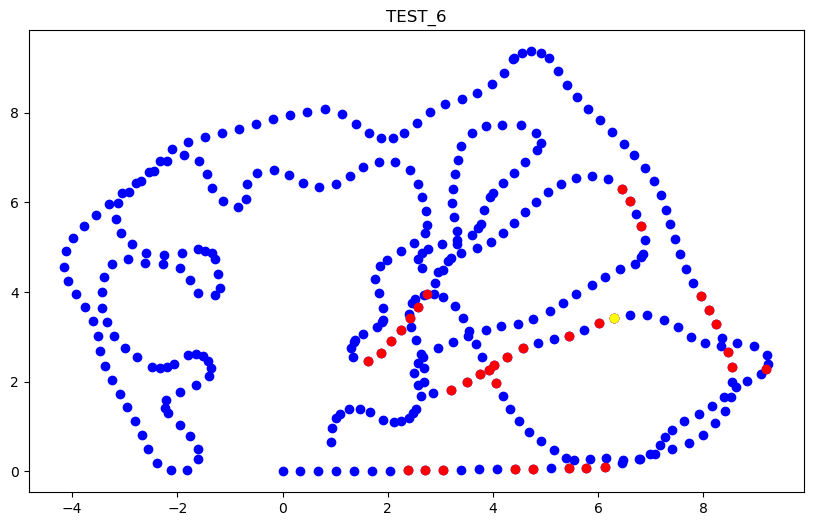

In [15]:
FILTER = True
N = 10
TEST = 'test_6'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_vgg19 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_vgg19

def process_vgg19(query_images_vgg19, vgg19, vgg19_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_vgg19:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        vgg19_feature = vgg19.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(vgg19_feature - db_feature) for db_feature in vgg19_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=0.9, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    #vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    vgg19_dataset = np.load(dataset_processed_path + 'vgg19.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_sift, query_images_vgg19 = load_images(image_reloc_path)

    # VGG19 processing
    start_time_vgg19 = time.time()
    top_indices_all_queries = process_vgg19(query_images_vgg19, vgg19, vgg19_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_vgg19 = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"VGG19: {round(end_time_vgg19 - start_time_vgg19, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_vgg19, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)
    #%timeit -r 2 -n 10 process_vgg19(query_images_vgg19, vgg19, vgg19_dataset)

# ResNet + SIFT

In [8]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from sklearn.cluster import DBSCAN
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image as kimage
import os
import time

dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'
dataset_file = 'filtered_dataset.npy'
dataset_array = np.load(dataset_processed_path + dataset_file)

resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
sift = cv.SIFT_create(nfeatures=100)

### TEST 1

Preprocess input: 1.0 ms
1/1 [==============================] - 0s 46ms/step
Predict: 156.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 46ms/step
Predict: 167.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 2.0 ms
1/1 [==============================] - 0s 38ms/step
Predict: 142.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Sum predict time:  0.46427249908447266
resnet: 0.485 seconds
SIFT:  0.086 seconds
TOTAL: 0.571 seconds


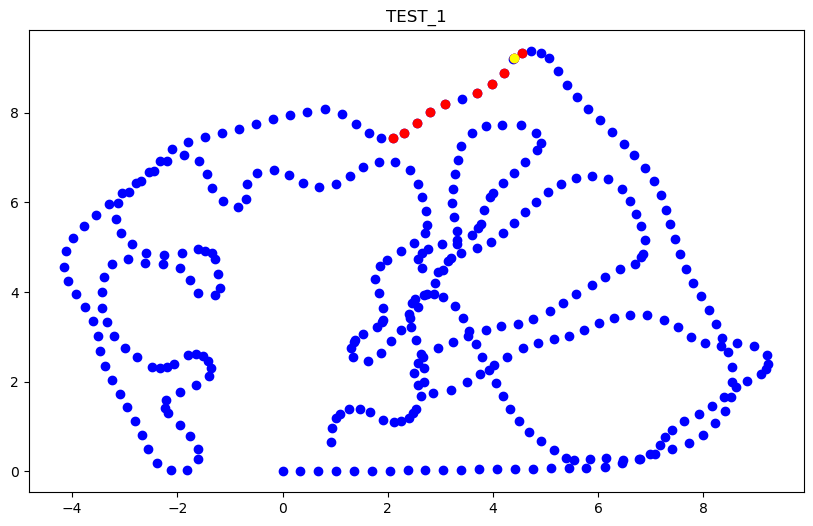

In [10]:
FILTER = True
N = 10
EPSILON = 0.9
MIN_SAMPLES = 3
TEST = 'test_1'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    #resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"resnet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)

### TEST 2

Preprocess input: 1.0 ms
1/1 [==============================] - 0s 51ms/step
Predict: 210.0 ms
Similarities: 6.0 ms
Top indices: 0.0 ms
Preprocess input: 3.0 ms
1/1 [==============================] - 0s 55ms/step
Predict: 200.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 41ms/step
Predict: 160.0 ms
Similarities: 8.0 ms
Top indices: 0.0 ms
Sum predict time:  0.5690562725067139
ResNet: 0.597 seconds
SIFT:  0.082 seconds
TOTAL: 0.679 seconds


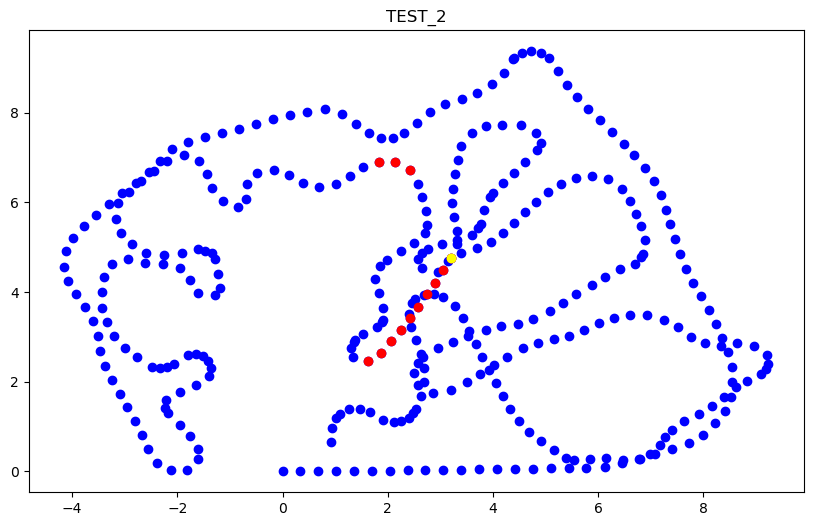

In [11]:
FILTER = True
EPSILON = 0.9
MIN_SAMPLES = 3
N = 10
TEST = 'test_2'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    #resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)

### TEST 3

Preprocess input: 1.0 ms
1/1 [==============================] - 0s 41ms/step
Predict: 200.0 ms
Similarities: 7.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 51ms/step
Predict: 193.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 40ms/step
Predict: 178.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 38ms/step
Predict: 130.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 44ms/step
Predict: 131.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 67ms/step
Predict: 234.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 42ms/step
Predict: 166.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==================

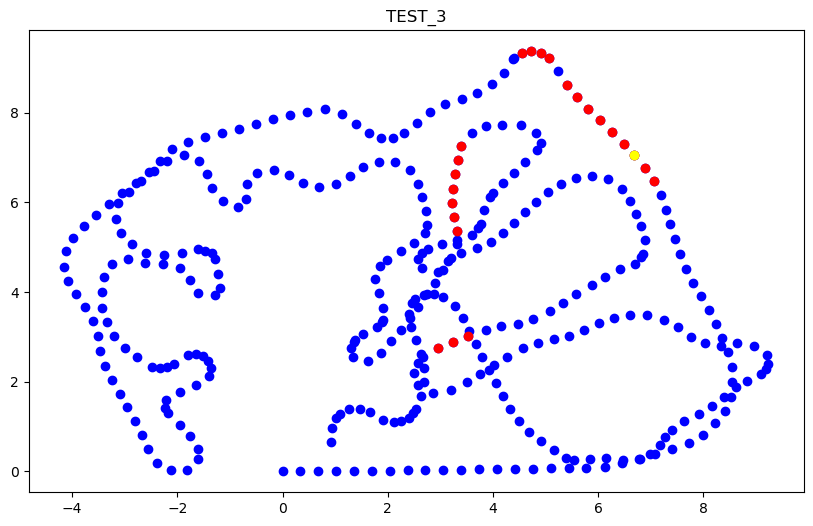

In [12]:
FILTER = True
N = 10
TEST = 'test_3'
EPSILON = 0.35
MIN_SAMPLES = 3
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    #resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"resnet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)

### TEST 4

Preprocess input: 1.0 ms
1/1 [==============================] - 0s 45ms/step
Predict: 181.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 37ms/step
Predict: 151.0 ms
Similarities: 6.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 43ms/step
Predict: 160.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 38ms/step
Predict: 144.0 ms
Similarities: 7.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 36ms/step
Predict: 141.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 41ms/step
Predict: 113.0 ms
Similarities: 8.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 32ms/step
Predict: 128.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==================

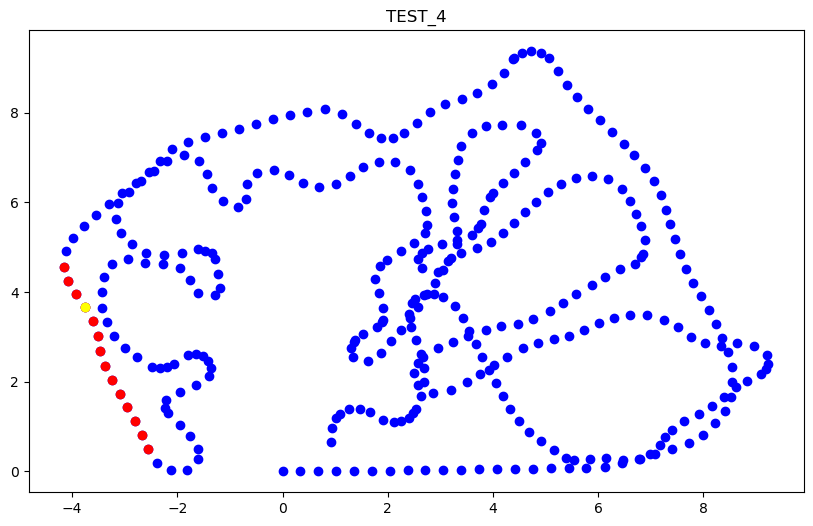

In [14]:
FILTER = True
N = 10
TEST = 'test_4'
EPSILON = 0.35
MIN_SAMPLES = 3
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    #resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"resnet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)

### TEST 5

Preprocess input: 1.0 ms
1/1 [==============================] - 0s 42ms/step
Predict: 180.0 ms
Similarities: 6.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 48ms/step
Predict: 214.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 52ms/step
Predict: 159.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 37ms/step
Predict: 163.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 40ms/step
Predict: 138.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 41ms/step
Predict: 127.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 31ms/step
Predict: 137.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==================

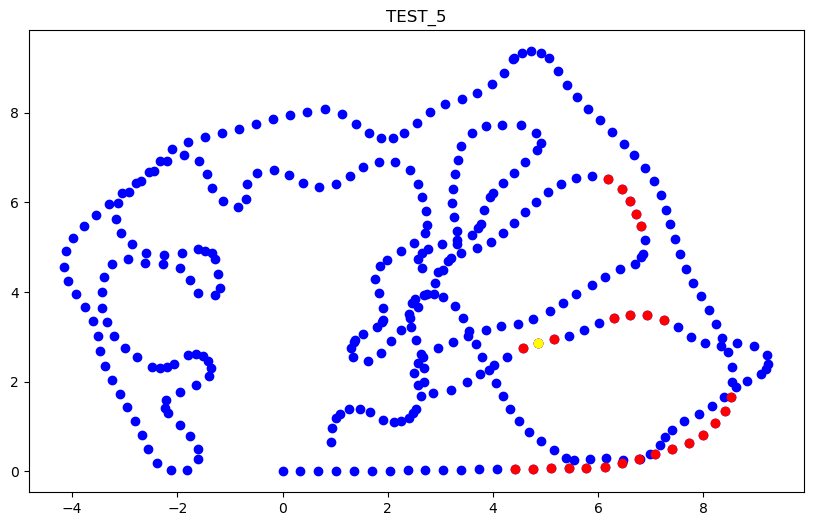

In [15]:
FILTER = True
N = 10
TEST = 'test_5'
EPSILON = 0.35
MIN_SAMPLES = 3
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    #resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"resnet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results ResNet + SIFT
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)

### TEST 6

Preprocess input: 1.0 ms
1/1 [==============================] - 0s 54ms/step
Predict: 211.0 ms
Similarities: 7.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 41ms/step
Predict: 168.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 37ms/step
Predict: 162.0 ms
Similarities: 7.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 47ms/step
Predict: 122.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 37ms/step
Predict: 126.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 49ms/step
Predict: 139.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 37ms/step
Predict: 124.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==================

ValueError: 'c' argument has 42 elements, which is inconsistent with 'x' and 'y' with size 25.

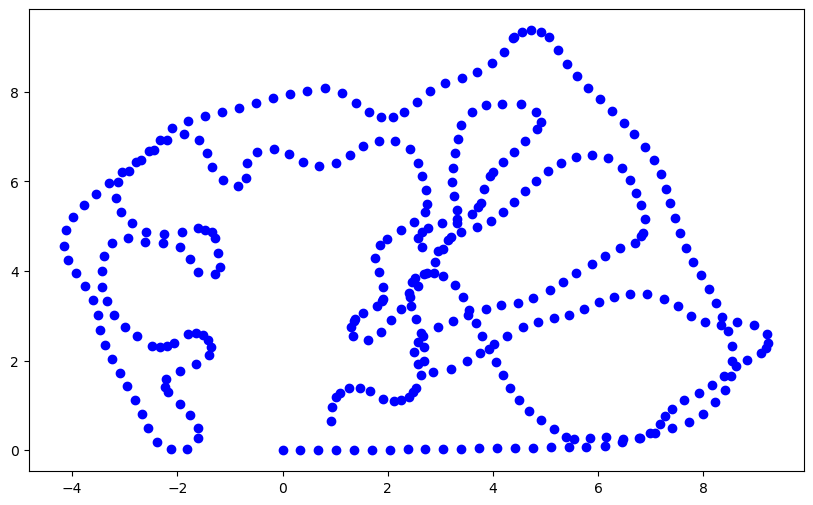

In [17]:
FILTER = True
N = 10
TEST = 'test_6'
EPSILON = 1
MIN_SAMPLES = 4
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    #resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"resnet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results ResNet + SIFT
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)

### TEST 7

Preprocess input: 0.0 ms
1/1 [==============================] - 1s 539ms/step
Predict: 859.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 20ms/step
Predict: 126.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 30ms/step
Predict: 131.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 25ms/step
Predict: 125.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 20ms/step
Predict: 83.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 22ms/step
Predict: 88.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 23ms/step
Predict: 85.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [====================

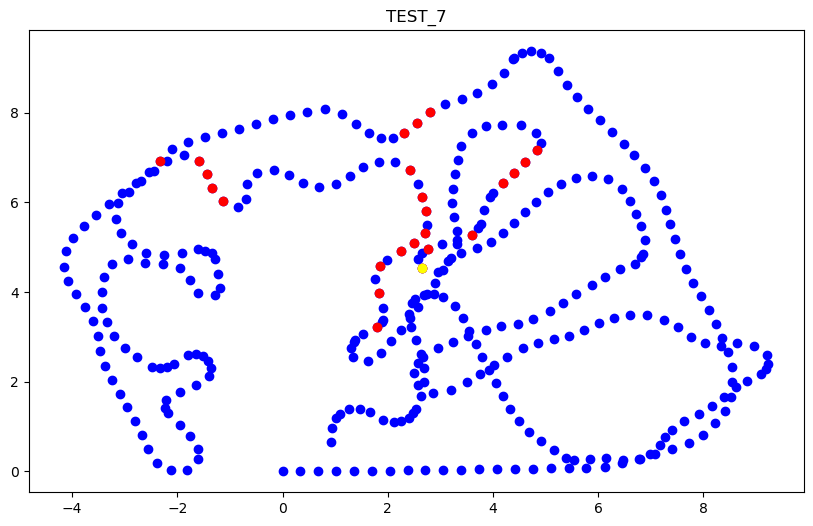

In [6]:
FILTER = True
N = 10
TEST = 'test_7'
EPSILON = 1
MIN_SAMPLES = 4
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    #resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results ResNet + SIFT
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)

# DATABASE v2

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from PIL import Image
from sklearn.cluster import DBSCAN
import os

dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'
dataset_file = 'filtered_dataset_v2.npy' 
dataset_array = np.load(dataset_processed_path + dataset_file)

### Visualize SIFT features

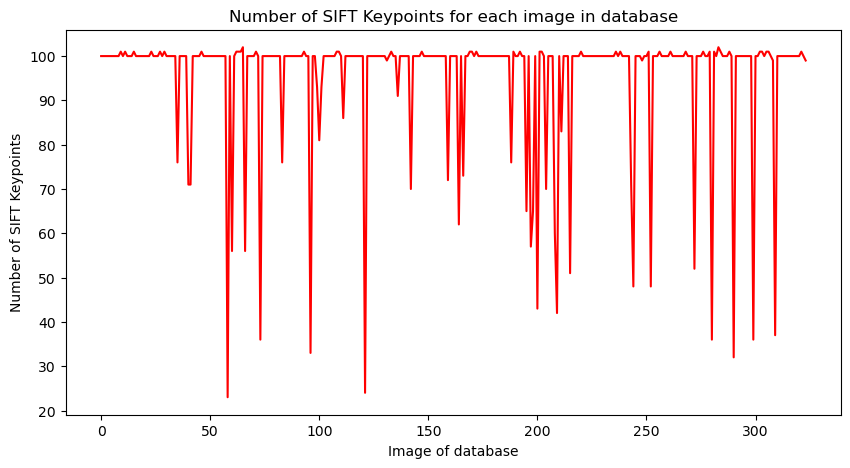

Number of images with exactly 100 keypoints:  241
Number of images with less than 80.0 keypoints:  33
Number of images with 0 keypoints:  0


In [6]:
# Initialize SIFT detector
num_features = 100
sift = cv.SIFT_create(nfeatures=num_features)

# Path to image folder
image_folder = dataset_processed_path

# Get list of image file names
image_files = os.listdir(image_folder)
# Filter the list to include only .jpg files
image_files = [file for file in image_files if file.endswith('.jpg')]

# Initialize lists to store image names and number of keypoints
image_names = []
num_keypoints = []
i = 0
num_images_100_keypoints = 0
num_images_less_than_100_keypoints = 0
num_0_keypoint = 0

# Iterate over each image
for image_file in image_files:
    # Load image
    image = cv.imread(os.path.join(image_folder, image_file), cv.IMREAD_GRAYSCALE)

    # Compute sift descriptors
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is None:
        image_names.append(i)
        num_keypoints.append(0)
        num_images_less_than_100_keypoints += 1
        num_0_keypoint += 1
    else:
        # Store image name and number of keypoints
        image_names.append(i)
        num_keypoints.append(len(descriptors))
        if len(descriptors) == num_features:
            num_images_100_keypoints += 1
        elif len(descriptors) < num_features*0.85:
            num_images_less_than_100_keypoints += 1
    i = i+1

# Create plot
plt.figure(figsize=(10, 5))
plt.plot(image_names, num_keypoints,'r')
plt.xlabel('Image of database')
plt.ylabel('Number of SIFT Keypoints')
plt.title('Number of SIFT Keypoints for each image in database')  
plt.show()



print(f"Number of images with exactly {num_features} keypoints: ", num_images_100_keypoints)
print(f"Number of images with less than {num_features*0.80} keypoints: ", num_images_less_than_100_keypoints)
print("Number of images with 0 keypoints: ", num_0_keypoint)

### Create SIFT database v2

In [3]:
# Initialize sift
num_features = 100
sift = cv.SIFT_create(nfeatures=num_features)

# Path to your image folder
image_folder = dataset_processed_path

# Get list of image file names
image_files = os.listdir(image_folder)
# Filter the list to include only .jpg files
image_files = [file for file in image_files if file.endswith('.jpg')]

# sift dataset
sift_descriptors = []

# Initialize lists to store image names and number of keypoints
image_names = []
num_keypoints = []
i = 0
# Iterate over each image
for image_file in image_files:
    # Load image
    image = cv.imread(os.path.join(image_folder, image_file), 0)  # load in grayscale

    # Compute sift descriptors
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is None:
        # Initialize descriptors as an array of zeros
        descriptors = np.zeros((num_features, 128))
    else:
        if len(descriptors) < num_features:
            delta = num_features - len(descriptors)
            descriptors = np.concatenate((descriptors, np.zeros((delta, 128))))
        elif len(descriptors) > num_features:
            descriptors = descriptors[:num_features, :]
    
    # Add descriptors to sift dataset list; if there are less than 100 keypoints, add zeros
    sift_descriptors.append(descriptors)

# Convert sift dataset to numpy array (images, keypoints, features)
sift_descriptors = np.array(sift_descriptors, dtype=float)
np.save(dataset_processed_path + 'sift.npy', sift_descriptors)

# IMAGE RETRIEVAL

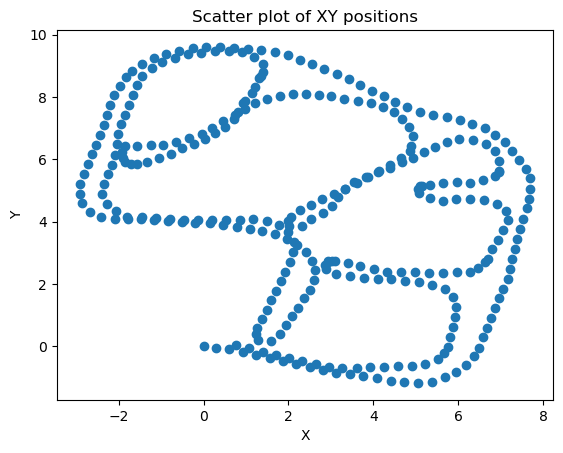

In [4]:
filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')
positions = filtered_dataset[:, 1:3]

# Create scatter plot
plt.scatter(positions[:, 0], positions[:, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter plot of XY positions')
plt.show()

### VGG19 + SIFT

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from sklearn.cluster import DBSCAN
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image as kimage
import os
import re
import time

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-12-11 16:04:26.195964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 16:04:26.196051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 16:04:26.229738: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 16:04:26.300358: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use 

### TEST 1

2023-12-11 16:04:33.966598: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-11 16:04:34.091624: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-11 16:04:34.091684: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-11 16:04:34.093733: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-11 16:04:34.093807: I external/local_xla/xla/stream_executor

Preprocess input: 0.0 ms


2023-12-11 16:04:35.198028: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


1/1 [==============================] - 1s 930ms/step
Predict: 977.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 15ms/step
Predict: 57.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 16ms/step
Predict: 60.0 ms
Similarities: 1.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 15ms/step
Predict: 55.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 17ms/step
Predict: 56.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 16ms/step
Predict: 61.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 18ms/step
Predict: 58.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 14ms/step
P

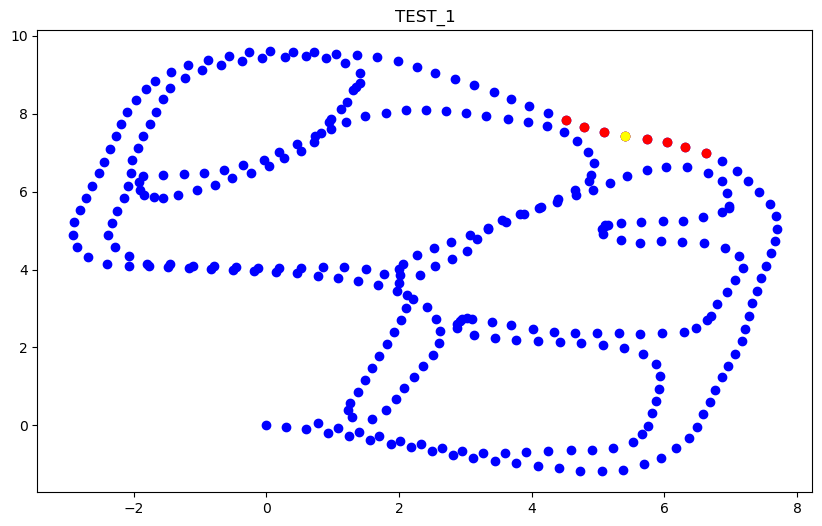

In [3]:
FILTER = True
N = 5
TEST = 'test_1'
EPSILON = 0.5
MIN_SAMPLES = 3
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_vgg19 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_vgg19

def process_vgg19(query_images_vgg19, vgg19, vgg19_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_vgg19:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        vgg19_feature = vgg19.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(vgg19_feature - db_feature) for db_feature in vgg19_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    vgg19_dataset = np.load(dataset_processed_path + 'vgg19.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/{TEST}/'
    query_images_sift, query_images_vgg19 = load_images(image_reloc_path)

    # resnet processing
    start_time_vgg19 = time.time()
    top_indices_all_queries = process_vgg19(query_images_vgg19, vgg19, vgg19_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_vgg19 = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"VGG19: {round(end_time_vgg19 - start_time_vgg19, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_vgg19, 3)} seconds")

    # Plot results ResNet + SIFT
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)

### TEST 2

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 91ms/step
Predict: 266.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 17ms/step
Predict: 71.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 15ms/step
Predict: 53.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 16ms/step
Predict: 54.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 15ms/step
Predict: 56.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 16ms/step
Predict: 62.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 15ms/step
Predict: 59.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [========================

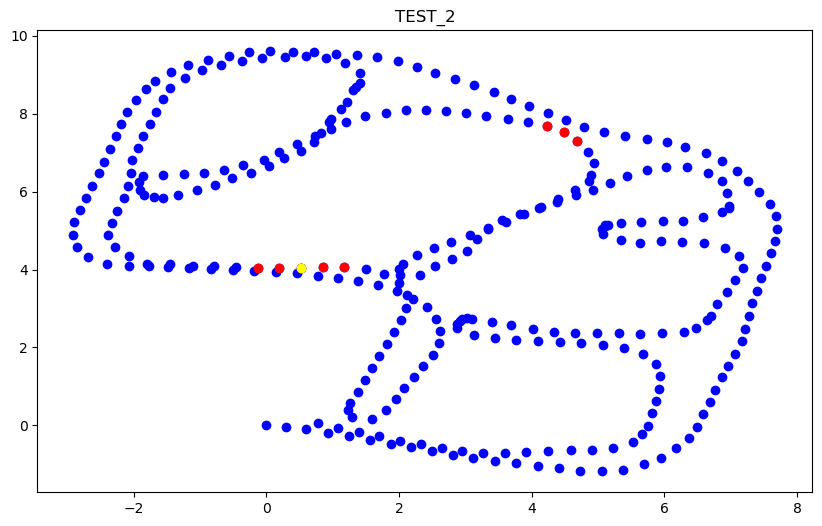

In [4]:
FILTER = True
N = 5
TEST = 'test_2'
EPSILON = 0.5
MIN_SAMPLES = 3
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_vgg19 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_vgg19

def process_vgg19(query_images_vgg19, vgg19, vgg19_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_vgg19:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        vgg19_feature = vgg19.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(vgg19_feature - db_feature) for db_feature in vgg19_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    vgg19_dataset = np.load(dataset_processed_path + 'vgg19.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/{TEST}/'
    query_images_sift, query_images_vgg19 = load_images(image_reloc_path)

    # resnet processing
    start_time_vgg19 = time.time()
    top_indices_all_queries = process_vgg19(query_images_vgg19, vgg19, vgg19_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_vgg19 = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"VGG19: {round(end_time_vgg19 - start_time_vgg19, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_vgg19, 3)} seconds")

    # Plot results ResNet + SIFT
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)

### TEST 3

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 89ms/step
Predict: 265.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 16ms/step
Predict: 166.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 16ms/step
Predict: 97.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 16ms/step
Predict: 99.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 17ms/step
Predict: 67.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 18ms/step
Predict: 77.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 19ms/step
Predict: 80.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [=======================

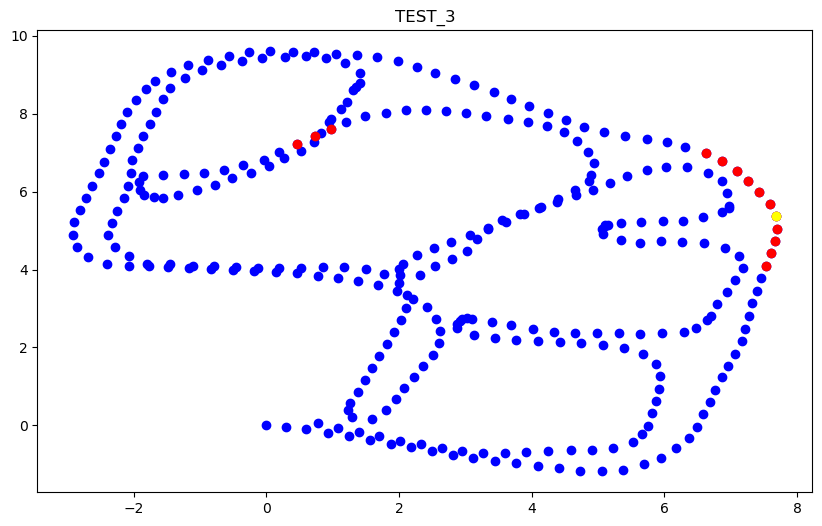

In [5]:
FILTER = True
N = 5
TEST = 'test_3'
EPSILON = 0.5
MIN_SAMPLES = 3
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_vgg19 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_vgg19

def process_vgg19(query_images_vgg19, vgg19, vgg19_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_vgg19:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        vgg19_feature = vgg19.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(vgg19_feature - db_feature) for db_feature in vgg19_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    vgg19_dataset = np.load(dataset_processed_path + 'vgg19.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/{TEST}/'
    query_images_sift, query_images_vgg19 = load_images(image_reloc_path)

    # resnet processing
    start_time_vgg19 = time.time()
    top_indices_all_queries = process_vgg19(query_images_vgg19, vgg19, vgg19_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_vgg19 = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"VGG19: {round(end_time_vgg19 - start_time_vgg19, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_vgg19, 3)} seconds")

    # Plot results ResNet + SIFT
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)

### TEST 4

In [1]:
FILTER = True
N = 5
TEST = 'test_4'
EPSILON = 0.5
MIN_SAMPLES = 4
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_vgg19 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_vgg19

def process_vgg19(query_images_vgg19, vgg19, vgg19_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_vgg19:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        vgg19_feature = vgg19.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(vgg19_feature - db_feature) for db_feature in vgg19_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    vgg19_dataset = np.load(dataset_processed_path + 'vgg19.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/{TEST}/'
    query_images_sift, query_images_vgg19 = load_images(image_reloc_path)

    # resnet processing
    start_time_vgg19 = time.time()
    top_indices_all_queries = process_vgg19(query_images_vgg19, vgg19, vgg19_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_vgg19 = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"VGG19: {round(end_time_vgg19 - start_time_vgg19, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_vgg19, 3)} seconds")

    # Plot results ResNet + SIFT
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)

NameError: name 'VGG19' is not defined

### TEST 5

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 88ms/step
Predict: 261.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 17ms/step
Predict: 177.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 17ms/step
Predict: 102.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 14ms/step
Predict: 99.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 16ms/step
Predict: 95.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 16ms/step
Predict: 99.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 15ms/step
Predict: 61.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [======================

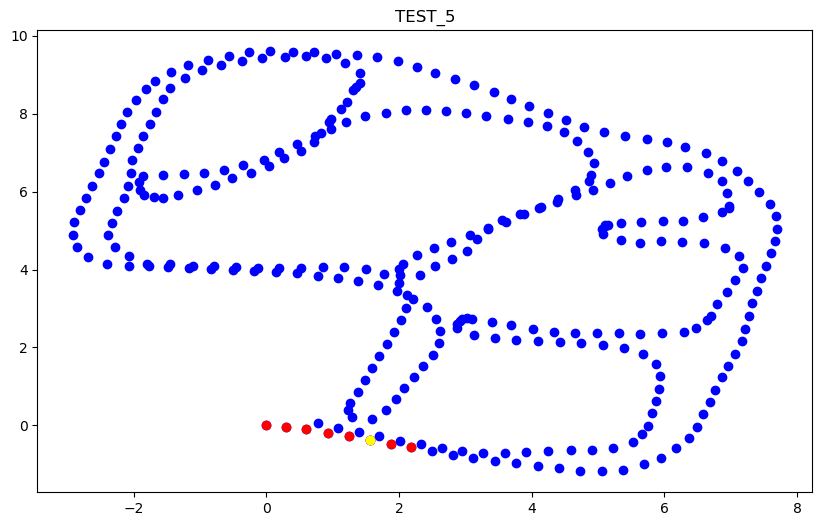

In [7]:
FILTER = True
N = 5
TEST = 'test_5'
EPSILON = 0.5
MIN_SAMPLES = 3
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_vgg19 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_vgg19

def process_vgg19(query_images_vgg19, vgg19, vgg19_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_vgg19:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        vgg19_feature = vgg19.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(vgg19_feature - db_feature) for db_feature in vgg19_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    vgg19_dataset = np.load(dataset_processed_path + 'vgg19.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/{TEST}/'
    query_images_sift, query_images_vgg19 = load_images(image_reloc_path)

    # resnet processing
    start_time_vgg19 = time.time()
    top_indices_all_queries = process_vgg19(query_images_vgg19, vgg19, vgg19_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_vgg19 = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"VGG19: {round(end_time_vgg19 - start_time_vgg19, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_vgg19, 3)} seconds")

    # Plot results ResNet + SIFT
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)

### TEST 6

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 87ms/step
Predict: 260.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 18ms/step
Predict: 92.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 17ms/step
Predict: 56.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 17ms/step
Predict: 58.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 16ms/step
Predict: 57.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 15ms/step
Predict: 54.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 15ms/step
Predict: 59.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [========================

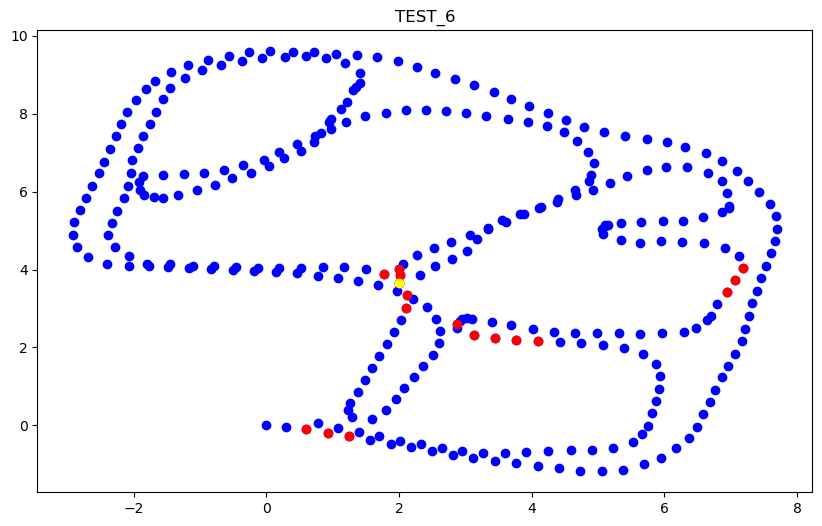

In [8]:
FILTER = True
N = 5
TEST = 'test_6'
EPSILON = 0.5
MIN_SAMPLES = 3
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_vgg19 = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_vgg19

def process_vgg19(query_images_vgg19, vgg19, vgg19_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_vgg19:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        vgg19_feature = vgg19.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(vgg19_feature - db_feature) for db_feature in vgg19_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    vgg19_dataset = np.load(dataset_processed_path + 'vgg19.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/{TEST}/'
    query_images_sift, query_images_vgg19 = load_images(image_reloc_path)

    # resnet processing
    start_time_vgg19 = time.time()
    top_indices_all_queries = process_vgg19(query_images_vgg19, vgg19, vgg19_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_vgg19 = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"VGG19: {round(end_time_vgg19 - start_time_vgg19, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_vgg19, 3)} seconds")

    # Plot results ResNet + SIFT
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)

# RESNET + SIFT

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from sklearn.cluster import DBSCAN
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image as kimage
import os
import time

dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'
dataset_file = 'filtered_dataset_v2.npy'
dataset_array = np.load(dataset_processed_path + dataset_file)

### TEST 1

Preprocess input: 0.0 ms
1/1 [==============================] - 1s 508ms/step
Predict: 613.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 26ms/step
Predict: 128.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 19ms/step
Predict: 120.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 27ms/step
Predict: 86.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 24ms/step
Predict: 78.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 22ms/step
Predict: 87.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 27ms/step
Predict: 89.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [=====================

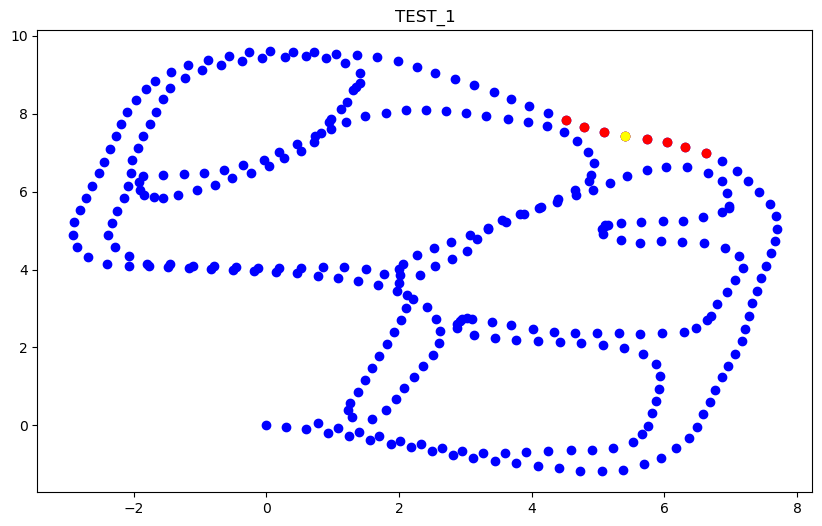

In [12]:
FILTER = True
EPS = 0.5
MIN_SAMPLES = 3
N = 5
TEST = 'test_1'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)

### TEST 2

Preprocess input: 0.0 ms
1/1 [==============================] - 1s 547ms/step
Predict: 659.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 20ms/step
Predict: 129.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 18ms/step
Predict: 119.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 18ms/step
Predict: 115.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 18ms/step
Predict: 80.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 24ms/step
Predict: 82.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 22ms/step
Predict: 81.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [====================

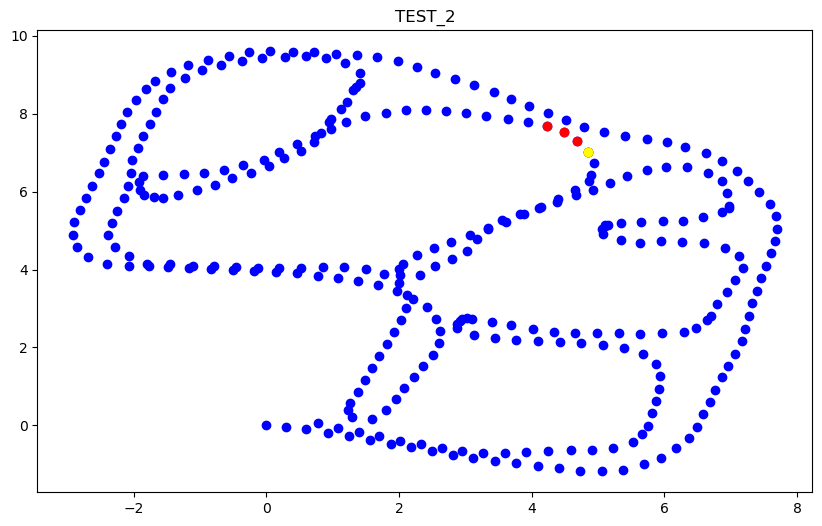

In [14]:
FILTER = True
EPS = 0.5
MIN_SAMPLES = 3
N = 5
TEST = 'test_2'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)

### TEST 3

Preprocess input: 0.0 ms
1/1 [==============================] - 1s 573ms/step
Predict: 683.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 19ms/step
Predict: 184.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 24ms/step
Predict: 131.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 18ms/step
Predict: 125.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 25ms/step
Predict: 130.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 18ms/step
Predict: 78.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 21ms/step
Predict: 77.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [===================

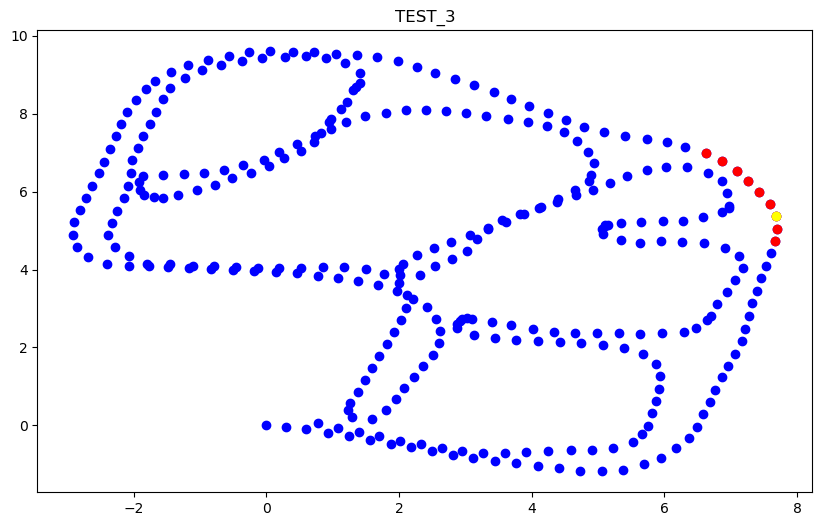

In [17]:
FILTER = True
EPS = 0.5
MIN_SAMPLES = 3
N = 5
TEST = 'test_3'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)

### TEST 4

Preprocess input: 0.0 ms
1/1 [==============================] - 1s 537ms/step
Predict: 654.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 18ms/step
Predict: 121.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 23ms/step
Predict: 125.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 23ms/step
Predict: 80.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 19ms/step
Predict: 83.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 21ms/step
Predict: 80.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 21ms/step
Predict: 86.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [=====================

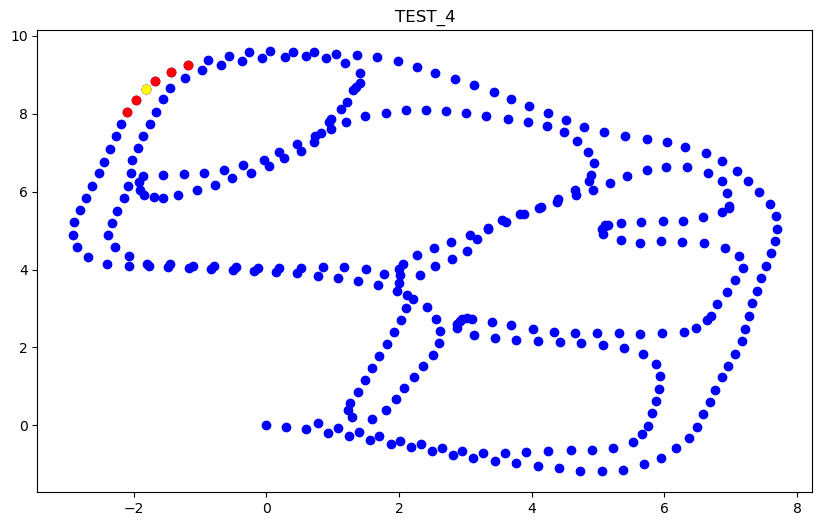

In [18]:
FILTER = True
EPS = 0.5
MIN_SAMPLES = 3
N = 5
TEST = 'test_4'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)

### TEST 5

Preprocess input: 0.0 ms
1/1 [==============================] - 1s 555ms/step
Predict: 663.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 19ms/step
Predict: 122.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 21ms/step
Predict: 129.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 21ms/step
Predict: 84.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 21ms/step
Predict: 86.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 20ms/step
Predict: 83.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 20ms/step
Predict: 84.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [=====================

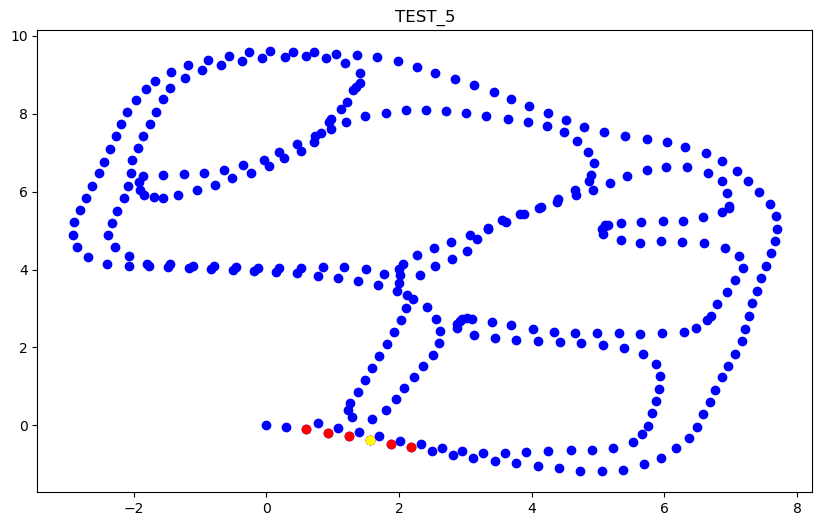

In [21]:
FILTER = True
EPS = 0.5
MIN_SAMPLES = 3
N = 5
TEST = 'test_5'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)

### TEST 6

Preprocess input: 0.0 ms
1/1 [==============================] - 1s 553ms/step
Predict: 663.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 19ms/step
Predict: 126.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 18ms/step
Predict: 119.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 20ms/step
Predict: 85.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 19ms/step
Predict: 84.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 25ms/step
Predict: 83.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 27ms/step
Predict: 91.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [=====================

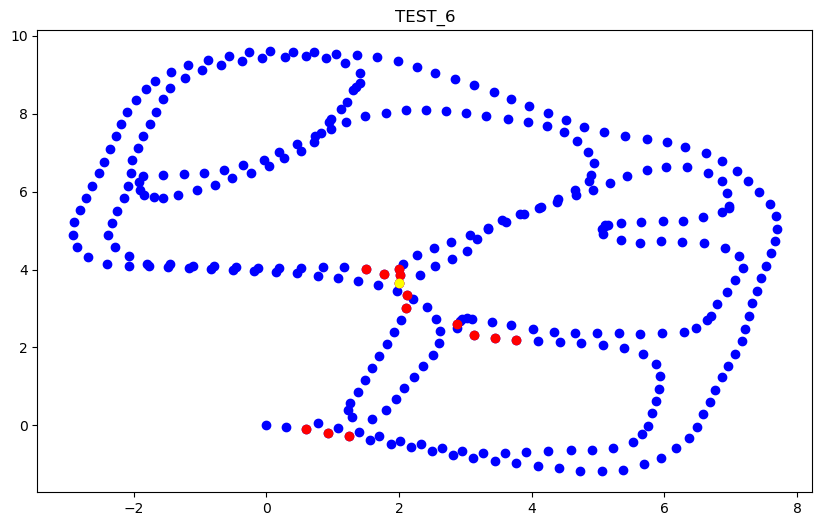

In [22]:
FILTER = True
EPS = 0.5
MIN_SAMPLES = 3
N = 5
TEST = 'test_6'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose)

# TEST WITH AMCL POSES REFERENCE

### TEST 1

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from sklearn.cluster import DBSCAN
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image as kimage
import os
import time

resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
sift = cv.SIFT_create(nfeatures=100)
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'
dataset_file = 'filtered_dataset_v2.npy'
dataset_array = np.load(dataset_processed_path + dataset_file)
dataset_array[:1]


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-12-13 20:09:20.200048: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 20:09:20.200186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 20:09:20.261368: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 20:09:20.395655: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use 

array([[ 0.00000000e+00,  1.26900955e-06, -1.88639280e-07,
         1.00000000e-02,  0.00000000e+00,  0.00000000e+00,
        -7.23014980e-02,  9.97382822e-01]])

Preprocess input: 1.0 ms
1/1 [==============================] - 0s 42ms/step
Predict: 225.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 50ms/step
Predict: 199.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 43ms/step
Predict: 164.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 48ms/step
Predict: 153.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 50ms/step
Predict: 171.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 37ms/step
Predict: 149.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 2.0 ms
1/1 [==============================] - 0s 44ms/step
Predict: 146.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==================

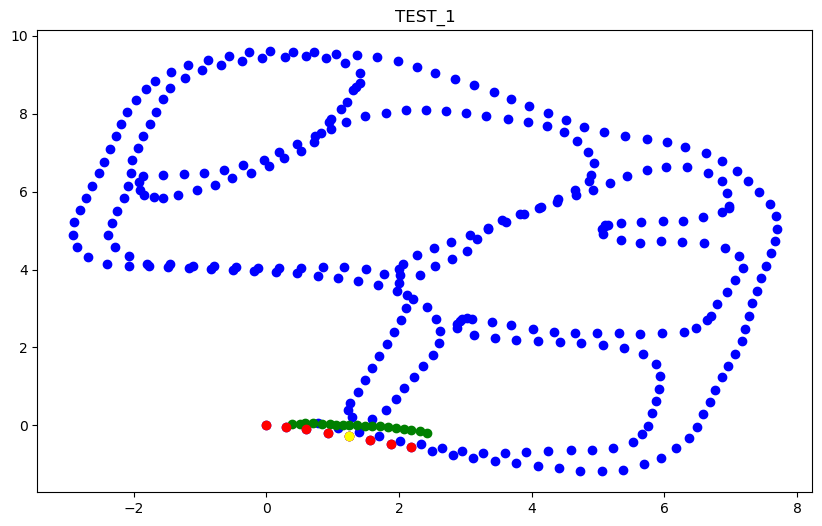

In [18]:
FILTER = True
EPS = 0.5
MIN_SAMPLES = 3
N = 5
TEST = 'test_1'

def load_images(image_reloc_path):
    image_list = [f for f in os.listdir(image_reloc_path) if f.endswith('.pgm') or f.endswith('.jpg') or f.endswith('.png')]
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(real_poses[:, 1].astype(float), real_poses[:, 2].astype(float), color='green')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    #resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/relocalization_pkg/reloc_test/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results
    real_poses = np.load(image_reloc_path + 'pose_array_v2.npy')
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses)

### TEST 2

Preprocess input: 3.0 ms
1/1 [==============================] - 0s 54ms/step
Predict: 224.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 41ms/step
Predict: 179.0 ms
Similarities: 7.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 38ms/step
Predict: 167.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 44ms/step
Predict: 177.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 36ms/step
Predict: 157.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 36ms/step
Predict: 172.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 40ms/step
Predict: 174.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==================

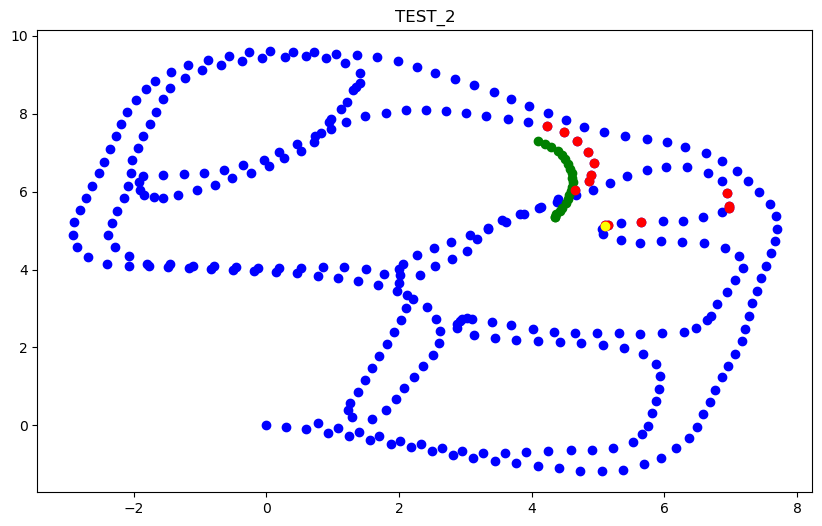

In [20]:
FILTER = True
EPS = 0.5
MIN_SAMPLES = 3
N = 5
TEST = 'test_2'

def load_images(image_reloc_path):
    image_list = [f for f in os.listdir(image_reloc_path) if f.endswith('.pgm') or f.endswith('.jpg') or f.endswith('.png')]
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(real_poses[:, 1].astype(float), real_poses[:, 2].astype(float), color='green')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    #resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/relocalization_pkg/reloc_test/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results
    real_poses = np.load(image_reloc_path + 'pose_array_v2.npy')
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses)

### TEST 3

Preprocess input: 1.0 ms
1/1 [==============================] - 0s 49ms/step
Predict: 224.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 38ms/step
Predict: 160.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 49ms/step
Predict: 197.0 ms
Similarities: 6.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 43ms/step
Predict: 183.0 ms
Similarities: 6.0 ms
Top indices: 0.0 ms
Preprocess input: 2.0 ms
1/1 [==============================] - 0s 45ms/step
Predict: 172.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 44ms/step
Predict: 196.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 3.0 ms
1/1 [==============================] - 0s 49ms/step
Predict: 188.0 ms
Similarities: 8.0 ms
Top indices: 2.0 ms
Preprocess input: 3.0 ms
1/1 [==================

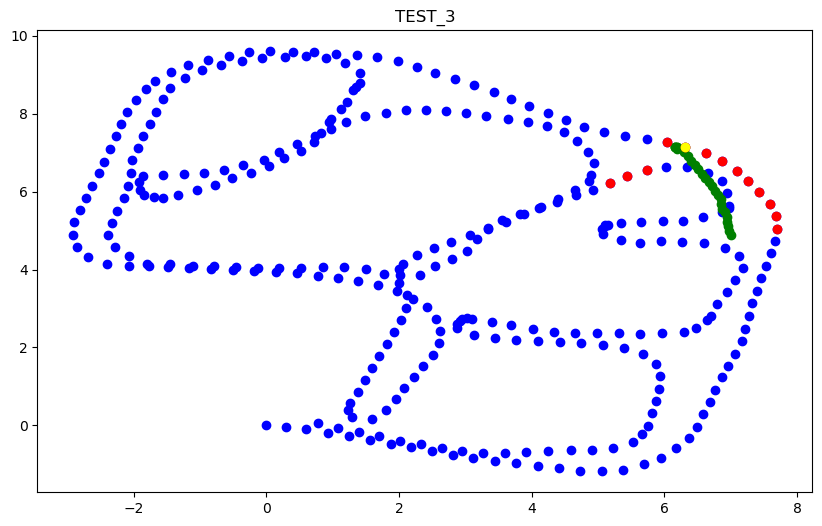

In [21]:
FILTER = True
EPS = 0.5
MIN_SAMPLES = 3
N = 5
TEST = 'test_3'

def load_images(image_reloc_path):
    image_list = [f for f in os.listdir(image_reloc_path) if f.endswith('.pgm') or f.endswith('.jpg') or f.endswith('.png')]
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(real_poses[:, 1].astype(float), real_poses[:, 2].astype(float), color='green')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    #resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/relocalization_pkg/reloc_test/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results
    real_poses = np.load(image_reloc_path + 'pose_array_v2.npy')
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses)

### TEST 4

Preprocess input: 2.0 ms
1/1 [==============================] - 0s 58ms/step
Predict: 257.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 53ms/step
Predict: 175.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 2.0 ms
1/1 [==============================] - 0s 72ms/step
Predict: 204.0 ms
Similarities: 9.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 47ms/step
Predict: 177.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 57ms/step
Predict: 215.0 ms
Similarities: 7.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 56ms/step
Predict: 189.0 ms
Similarities: 7.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 45ms/step
Predict: 174.0 ms
Similarities: 8.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==================

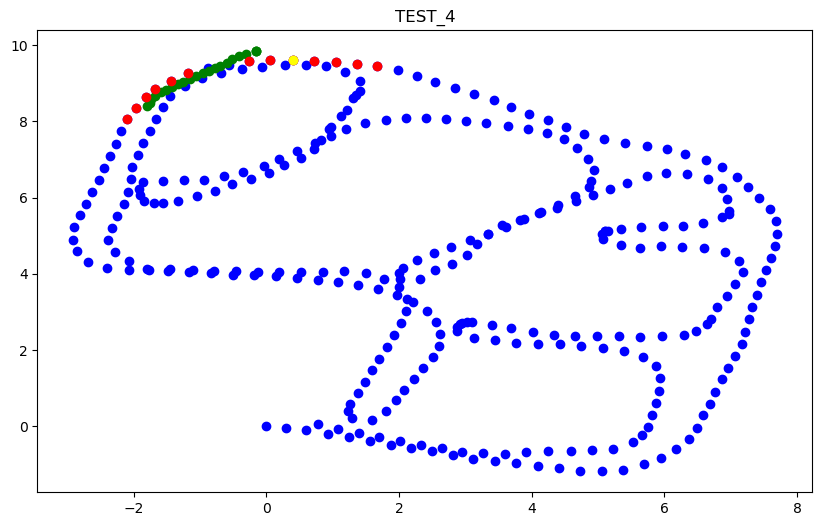

[6.39000000e+02 3.93673430e-01 9.59626290e+00 1.00000000e-02
 0.00000000e+00 0.00000000e+00 9.99824848e-01 1.87155969e-02]


In [24]:
FILTER = True
EPS = 0.5
MIN_SAMPLES = 3
N = 5
TEST = 'test_4'

def load_images(image_reloc_path):
    image_list = [f for f in os.listdir(image_reloc_path) if f.endswith('.pgm') or f.endswith('.jpg') or f.endswith('.png')]
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(real_poses[:, 1].astype(float), real_poses[:, 2].astype(float), color='green')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()
    print(best_match_pose)

if __name__ == "__main__":
    # Initialize models and datasets
    #resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/relocalization_pkg/reloc_test/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results
    real_poses = np.load(image_reloc_path + 'pose_array_v2.npy')
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses)

### TEST 5

Preprocess input: 1.0 ms
1/1 [==============================] - 0s 56ms/step
Predict: 270.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 45ms/step
Predict: 170.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 51ms/step
Predict: 164.0 ms
Similarities: 7.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 44ms/step
Predict: 155.0 ms
Similarities: 9.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 37ms/step
Predict: 163.0 ms
Similarities: 6.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 43ms/step
Predict: 177.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 43ms/step
Predict: 187.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==================

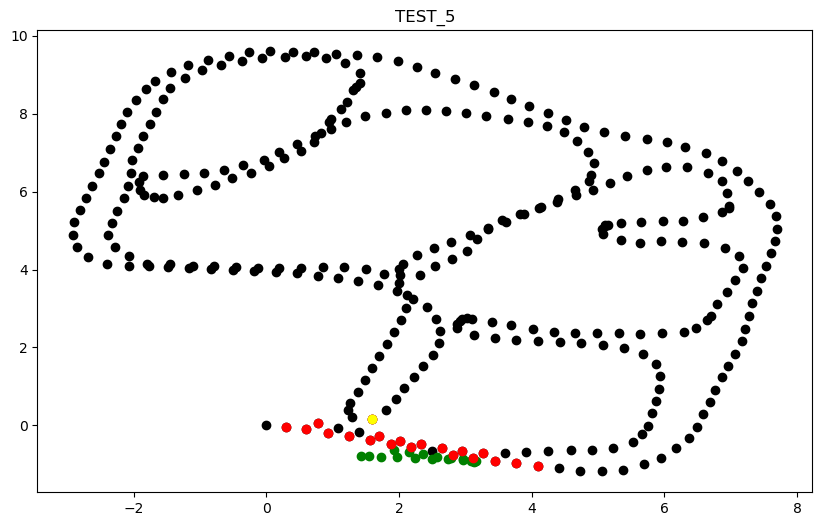

[1.13300000e+03 1.59903121e+00 1.66616950e-01 1.00000000e-02
 0.00000000e+00 0.00000000e+00 3.43747157e-01 9.39062241e-01]


In [26]:
FILTER = True
EPS = 0.5
MIN_SAMPLES = 3
N = 5
TEST = 'test_5'

def load_images(image_reloc_path):
    image_list = [f for f in os.listdir(image_reloc_path) if f.endswith('.pgm') or f.endswith('.jpg') or f.endswith('.png')]
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='black')
    plt.scatter(real_poses[:, 1].astype(float), real_poses[:, 2].astype(float), color='green')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()
    print(best_match_pose)

if __name__ == "__main__":
    # Initialize models and datasets
    #resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/relocalization_pkg/reloc_test/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results
    real_poses = np.load(image_reloc_path + 'pose_array_v2.npy')
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses)

### TEST 6

Preprocess input: 2.0 ms
1/1 [==============================] - 0s 49ms/step
Predict: 275.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 53ms/step
Predict: 188.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 44ms/step
Predict: 191.0 ms
Similarities: 4.0 ms
Top indices: 1.0 ms
Preprocess input: 2.0 ms
1/1 [==============================] - 0s 47ms/step
Predict: 187.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 39ms/step
Predict: 163.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 43ms/step
Predict: 182.0 ms
Similarities: 6.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 48ms/step
Predict: 166.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==================

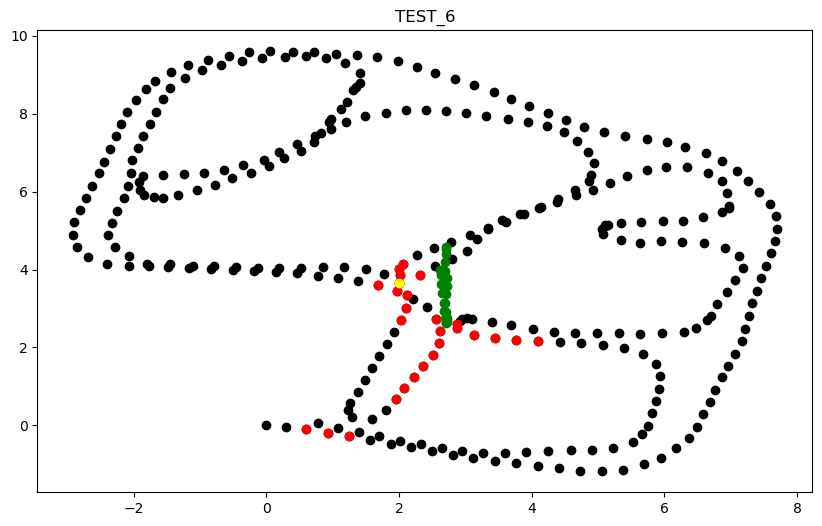

[ 9.70000000e+02  1.99524982e+00  3.64999660e+00  1.00000000e-02
  0.00000000e+00  0.00000000e+00 -5.21382220e-01  8.53323257e-01]


In [31]:
FILTER = True
EPS = 0.5
MIN_SAMPLES = 3
N = 5
TEST = 'test_6'

def load_images(image_reloc_path):
    image_list = [f for f in os.listdir(image_reloc_path) if f.endswith('.pgm') or f.endswith('.jpg') or f.endswith('.png')]
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='black')
    plt.scatter(real_poses[:, 1].astype(float), real_poses[:, 2].astype(float), color='green')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()
    print(best_match_pose)

if __name__ == "__main__":
    # Initialize models and datasets
    #resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/relocalization_pkg/reloc_test/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results
    real_poses = np.load(image_reloc_path + 'pose_array_v2.npy')
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses)

### TEST 7

Preprocess input: 1.0 ms
1/1 [==============================] - 0s 49ms/step
Predict: 199.0 ms
Similarities: 7.0 ms
Top indices: 1.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 48ms/step
Predict: 199.0 ms
Similarities: 6.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 45ms/step
Predict: 182.0 ms
Similarities: 7.0 ms
Top indices: 0.0 ms
Preprocess input: 2.0 ms
1/1 [==============================] - 0s 48ms/step
Predict: 187.0 ms
Similarities: 6.0 ms
Top indices: 0.0 ms
Preprocess input: 2.0 ms
1/1 [==============================] - 0s 75ms/step
Predict: 214.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 42ms/step
Predict: 184.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 44ms/step
Predict: 181.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==================

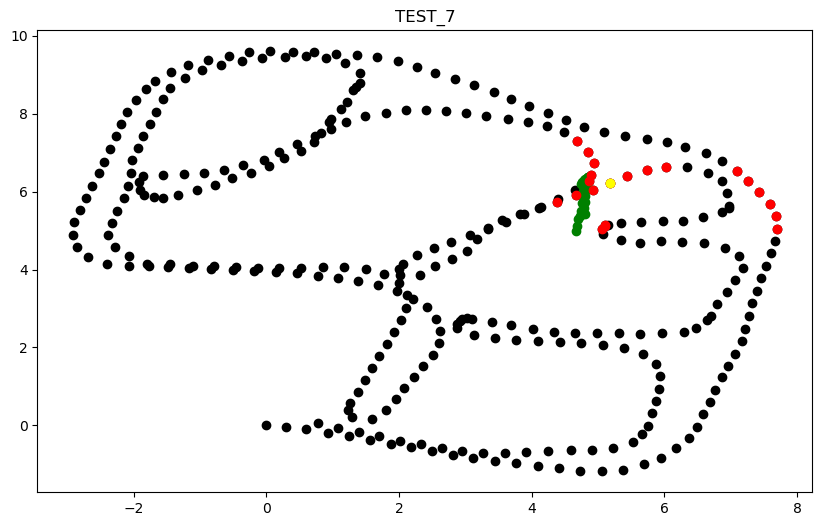

[2.42500000e+03 5.18610664e+00 6.21692573e+00 1.00000000e-02
 0.00000000e+00 0.00000000e+00 2.80596860e-01 9.59825715e-01]


In [34]:
FILTER = True
EPS = 0.5
MIN_SAMPLES = 3
N = 5
TEST = 'test_7'

def load_images(image_reloc_path):
    image_list = [f for f in os.listdir(image_reloc_path) if f.endswith('.pgm') or f.endswith('.jpg') or f.endswith('.png')]
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='black')
    plt.scatter(real_poses[:, 1].astype(float), real_poses[:, 2].astype(float), color='green')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()
    print(best_match_pose)

if __name__ == "__main__":
    # Initialize models and datasets
    #resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/relocalization_pkg/reloc_test/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results
    real_poses = np.load(image_reloc_path + 'pose_array_v2.npy')
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses)

### TEST 8

Preprocess input: 2.0 ms
1/1 [==============================] - 0s 52ms/step
Predict: 298.0 ms
Similarities: 6.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 53ms/step
Predict: 143.0 ms
Similarities: 8.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 45ms/step
Predict: 147.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 46ms/step
Predict: 144.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 49ms/step
Predict: 156.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 39ms/step
Predict: 172.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 45ms/step
Predict: 164.0 ms
Similarities: 6.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==================

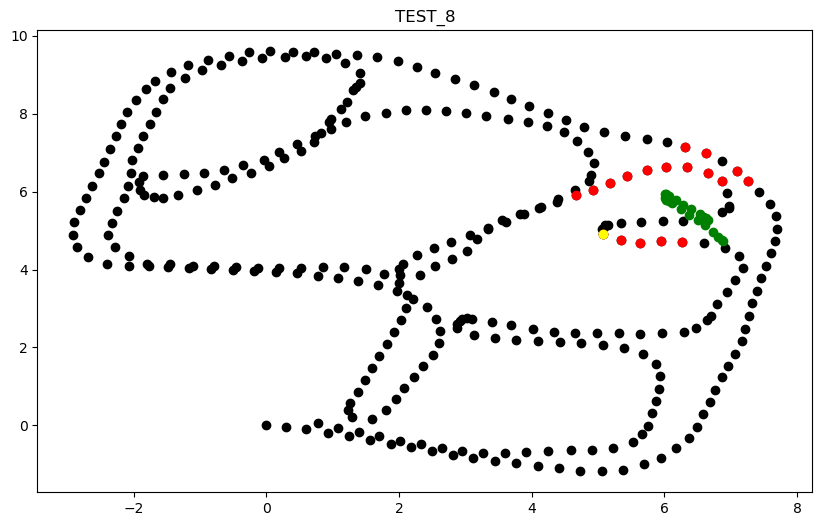

[ 2.58000000e+03  5.07415287e+00  4.92528260e+00  1.00000000e-02
  0.00000000e+00  0.00000000e+00 -3.30443071e-01  9.43825925e-01]


In [35]:
FILTER = True
EPS = 0.5
MIN_SAMPLES = 3
N = 5
TEST = 'test_8'

def load_images(image_reloc_path):
    image_list = [f for f in os.listdir(image_reloc_path) if f.endswith('.pgm') or f.endswith('.jpg') or f.endswith('.png')]
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='black')
    plt.scatter(real_poses[:, 1].astype(float), real_poses[:, 2].astype(float), color='green')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()
    print(best_match_pose)

if __name__ == "__main__":
    # Initialize models and datasets
    #resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/relocalization_pkg/reloc_test/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results
    real_poses = np.load(image_reloc_path + 'pose_array_v2.npy')
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses)

### TEST 9

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 20ms/step
Predict: 105.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 25ms/step
Predict: 120.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 18ms/step
Predict: 87.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 22ms/step
Predict: 88.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 19ms/step
Predict: 85.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 20ms/step
Predict: 93.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 27ms/step
Predict: 89.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [=======================

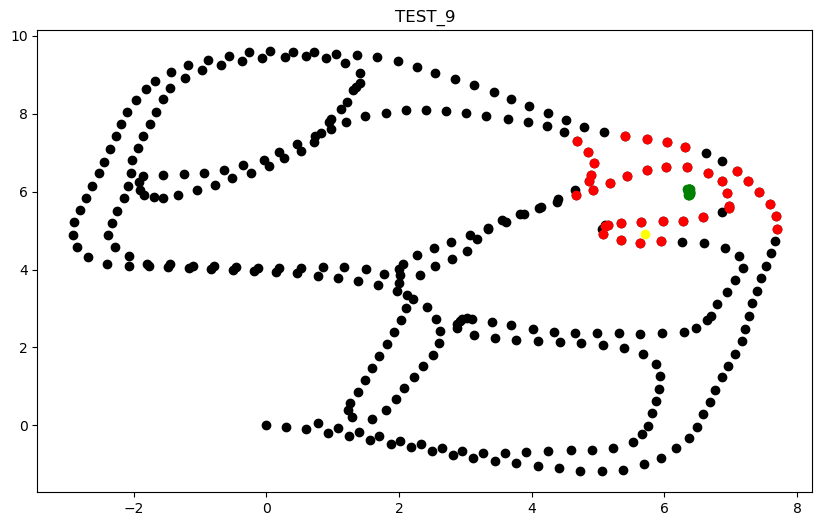

[2.27242857e+03 5.70807643e+00 4.91187096e+00 1.00000000e-02
 0.00000000e+00 0.00000000e+00 5.33040718e-02 6.95548764e-01]


In [43]:
FILTER = True
EPS = 0.5
MIN_SAMPLES = 3
N = 5
TEST = 'test_9'

def load_images(image_reloc_path):
    image_list = [f for f in os.listdir(image_reloc_path) if f.endswith('.pgm') or f.endswith('.jpg') or f.endswith('.png')]
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='black')
    plt.scatter(real_poses[:, 1].astype(float), real_poses[:, 2].astype(float), color='green')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()
    print(best_match_pose)

def calculate_centroid(filtered_dataset, top_indices_all_queries):
    # Get the poses of the top_indices_all_queries
    poses = filtered_dataset[top_indices_all_queries][1:8]
    # Calculate the centroid of the poses
    centroid = np.mean(poses, axis=0)
    return centroid

if __name__ == "__main__":
    # Initialize models and datasets
    #resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/relocalization_pkg/reloc_test/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = calculate_centroid(filtered_dataset, top_indices_all_queries)
    #best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"SIFT:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results
    real_poses = np.load(image_reloc_path + 'pose_array_v2.npy')
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses)

### TEST 10

Preprocess input: 1.0 ms
1/1 [==============================] - 0s 23ms/step
Predict: 147.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 29ms/step
Predict: 147.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 23ms/step
Predict: 123.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 19ms/step
Predict: 123.0 ms
Similarities: 3.0 ms
Top indices: 1.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 18ms/step
Predict: 83.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 18ms/step
Predict: 83.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 25ms/step
Predict: 83.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [=====================

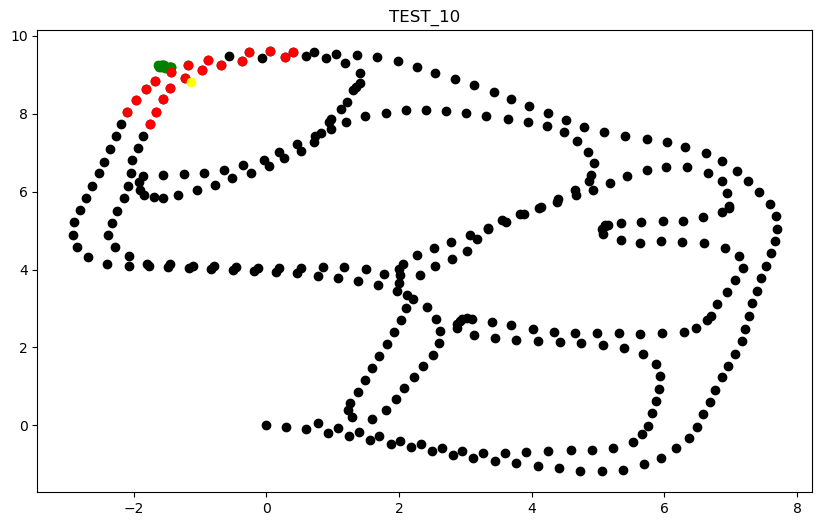

[ 1.53300000e+03 -1.13201637e+00  8.82536099e+00  1.00000000e-02
  0.00000000e+00  0.00000000e+00  3.59614281e-01  9.11434782e-01]


In [42]:
FILTER = True
EPS = 0.5
MIN_SAMPLES = 5
N = 5
TEST = 'test_10'

def load_images(image_reloc_path):
    image_list = [f for f in os.listdir(image_reloc_path) if f.endswith('.pgm') or f.endswith('.jpg') or f.endswith('.png')]
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='black')
    plt.scatter(real_poses[:, 1].astype(float), real_poses[:, 2].astype(float), color='green')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()
    print(best_match_pose)
    
def calculate_centroid(filtered_dataset, top_indices_all_queries):
    # Get the poses of the top_indices_all_queries
    poses = filtered_dataset[top_indices_all_queries][1:8]
    # Calculate the centroid of the poses
    centroid = np.mean(poses, axis=0)
    return centroid

if __name__ == "__main__":
    # Initialize models and datasets
    #resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/relocalization_pkg/reloc_test/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = calculate_centroid(filtered_dataset, top_indices_all_queries)
    #best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"Centroid:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results
    real_poses = np.load(image_reloc_path + 'pose_array_v2.npy')
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses)

### TEST 11

Preprocess input: 4.0 ms
1/1 [==============================] - 0s 67ms/step
Predict: 226.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 2.0 ms
1/1 [==============================] - 0s 47ms/step
Predict: 204.0 ms
Similarities: 7.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 52ms/step
Predict: 186.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 2.0 ms
1/1 [==============================] - 0s 49ms/step
Predict: 196.0 ms
Similarities: 6.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 50ms/step
Predict: 172.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 0.0 ms
1/1 [==============================] - 0s 47ms/step
Predict: 180.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 53ms/step
Predict: 204.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==================

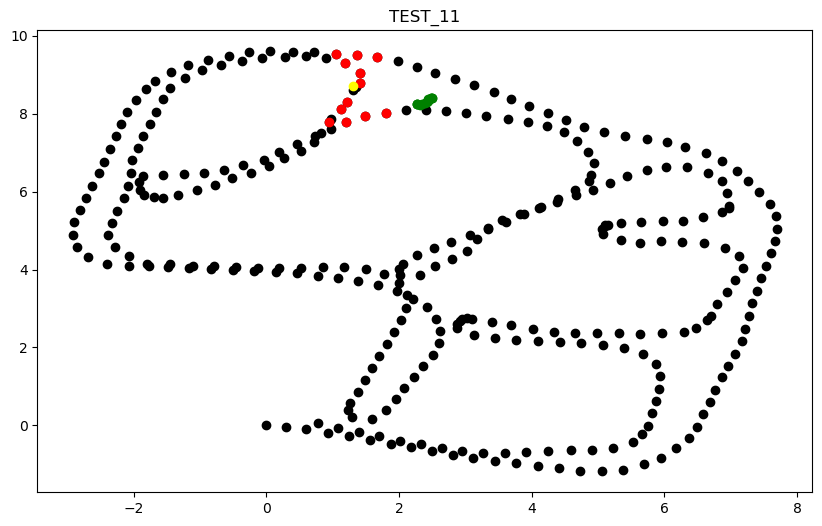

[ 1.36385714e+03  1.30583440e+00  8.72051033e+00  1.00000000e-02
  0.00000000e+00  0.00000000e+00 -4.10838426e-02  2.99171522e-01]


In [44]:
FILTER = True
EPS = 0.5
MIN_SAMPLES = 5
N = 5
TEST = 'test_11'

def load_images(image_reloc_path):
    image_list = [f for f in os.listdir(image_reloc_path) if f.endswith('.pgm') or f.endswith('.jpg') or f.endswith('.png')]
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='black')
    plt.scatter(real_poses[:, 1].astype(float), real_poses[:, 2].astype(float), color='green')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()
    print(best_match_pose)
    
def calculate_centroid(filtered_dataset, top_indices_all_queries):
    # Get the poses of the top_indices_all_queries
    poses = filtered_dataset[top_indices_all_queries][1:8]
    # Calculate the centroid of the poses
    centroid = np.mean(poses, axis=0)
    return centroid

if __name__ == "__main__":
    # Initialize models and datasets
    #resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/relocalization_pkg/reloc_test/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = calculate_centroid(filtered_dataset, top_indices_all_queries)
    #best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"Centroid:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results
    real_poses = np.load(image_reloc_path + 'pose_array_v2.npy')
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses)

### TEST 12

Preprocess input: 1.0 ms


1/1 [==============================] - 0s 79ms/step
Predict: 267.0 ms
Similarities: 9.0 ms
Top indices: 0.0 ms
Preprocess input: 3.0 ms
1/1 [==============================] - 0s 66ms/step
Predict: 292.0 ms
Similarities: 6.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 76ms/step
Predict: 242.0 ms
Similarities: 7.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 73ms/step
Predict: 238.0 ms
Similarities: 7.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 85ms/step
Predict: 292.0 ms
Similarities: 9.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 75ms/step
Predict: 198.0 ms
Similarities: 6.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 73ms/step
Predict: 198.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms
Preprocess input: 1.0 ms
1/1 [==============================] - 0s 70ms/s

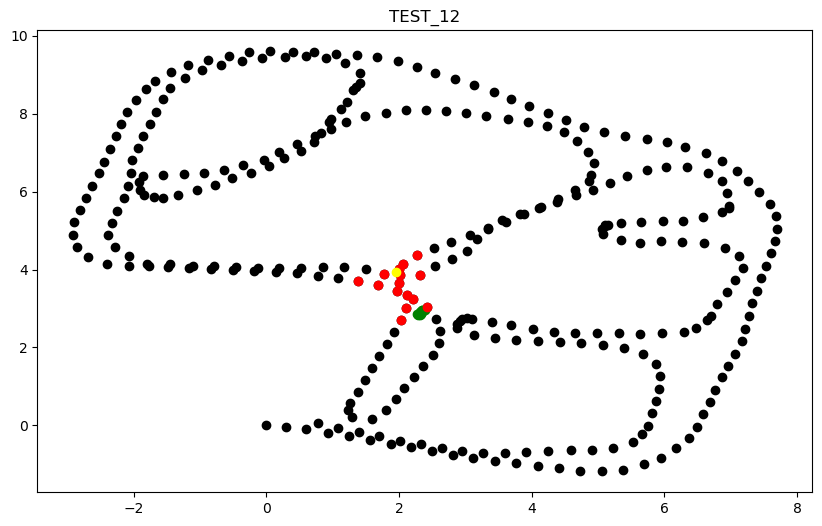

[1.98900000e+03 1.95884891e+00 3.93766266e+00 1.00000000e-02
 0.00000000e+00 0.00000000e+00 2.05544325e-01 4.35994386e-01]


In [3]:
FILTER = True
EPS = 0.5
MIN_SAMPLES = 6
N = 5
TEST = 'test_12'

def load_images(image_reloc_path):
    image_list = [f for f in os.listdir(image_reloc_path) if f.endswith('.pgm') or f.endswith('.jpg') or f.endswith('.png')]
    query_images_sift = [cv.imread(image_reloc_path + image_name, cv.IMREAD_GRAYSCALE) for image_name in image_list]
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_sift, query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset):
    # Get the last image in the query_images_sift list
    image_reloc = query_images_sift[-1]
    _, descriptors_query = sift.detectAndCompute(image_reloc, None)
    descriptors_query = descriptors_query.astype(np.float32)
    good_matches_per_image = np.zeros(len(top_indices_all_queries), dtype=int)
    for i, index in enumerate(top_indices_all_queries):
        db_descriptors = sift_dataset[index].astype(np.float32)
        matches = bf.knnMatch(descriptors_query, db_descriptors, k=2)
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        good_matches_per_image[i] = len(good_matches)
    best_match_index = np.argmax(good_matches_per_image)
    original_index = top_indices_all_queries[best_match_index]
    best_match_pose = filtered_dataset[original_index]
    return best_match_pose

def plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='black')
    plt.scatter(real_poses[:, 1].astype(float), real_poses[:, 2].astype(float), color='green')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.scatter(best_match_pose[1], best_match_pose[2], color='yellow')
    plt.title(f'{TEST.upper()}')
    plt.show()
    print(best_match_pose)
    
def calculate_centroid(filtered_dataset, top_indices_all_queries):
    # Get the poses of the top_indices_all_queries
    poses = filtered_dataset[top_indices_all_queries][1:8]
    # Calculate the centroid of the poses
    centroid = np.mean(poses, axis=0)
    return centroid

if __name__ == "__main__":
    # Initialize models and datasets
    #resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    #sift = cv.SIFT_create(nfeatures=100)
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    sift_dataset = np.load(dataset_processed_path + 'sift.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/relocalization_pkg/reloc_test/{TEST}/'
    query_images_sift, query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # SIFT processing
    start_time_sift = time.time()
    best_match_pose = calculate_centroid(filtered_dataset, top_indices_all_queries)
    #best_match_pose = process_sift(query_images_sift, sift, bf, sift_dataset, top_indices_all_queries, filtered_dataset)
    end_time_sift = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")
    print(f"Centroid:  {round(end_time_sift - start_time_sift, 3)} seconds") 
    print(f"TOTAL: {round(end_time_sift - start_time_resnet, 3)} seconds")

    # Plot results
    real_poses = np.load(image_reloc_path + 'pose_array_v2.npy')
    plot_results(filtered_dataset, top_indices_all_queries, best_match_pose, real_poses)